<style type="text/css">
#image {
  float:left;
  border-right:1px;
  width:145px;
  height:145px;
  margin-top:1px;
  margin-left:50px;
  padding:1px;
  background-color:#ffffff;
}
#subject {
  float:left;
  width:500px;
  border-radius: 10px; 
  height:130px;
  margin-top:6px;
  padding:1px;
  background-color:#b0bc04;
}
</style>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/ecole/IMT_Atlantique_logo.png" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

<font size="5">TAF MCE - UE Computer Vision | Lab Session 2 : Image interpretation </font></br></div>

<CENTER>
P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
R. Fablet <span style="color:blue">ronan.fablet@imt-atlantique.fr</span>
<CENTER>
</CENTER>
</div> 

***
This lab session is dedicated to **image interpretation** with deep learning. Two topics will be studied and discussed: 

1. **semantic segmentation** 
2. **object detection** (single-object localization)

For these purposes, we exploit an annotated dataset of pets, called **Oxford-IIIT-Pet** and covering 37 different breeds of cats and dogs. In particular, we focus on 200 images obtained for the *samoyed* category (https://www.robots.ox.ac.uk/~vgg/data/pets/getCategory.php?category=samoyed).

<div id="image">
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/1926_Samoyed_CHPolarLight.jpg" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

Each image is annotated with a breed label (*samoyed* in our case), a pixel level segmentation marking the body, and a tight bounding box around the head.
***

## I - Semantic segmentation

Our goal is to create a fully-automated **semantic segmentation model** with deep learning able to accurately delineate *samoyed* dogs in each image.

**Question 1 -** Read and display the three first images ("samoyed_i" with i={1,2,3}) with associated segmentation masks.

In [109]:
from skimage import io

folder_img = './samoyed_img/' 
folder_seg = './samoyed_seg/'
img1 = io.imread(folder_img+'samoyed_1.jpg')
seg1 = io.imread(folder_seg+'samoyed_1.png')
img2 = io.imread(folder_img+'samoyed_2.jpg')
seg2 = io.imread(folder_seg+'samoyed_2.png')
img3 = io.imread(folder_img+'samoyed_3.jpg')
seg3 = io.imread(folder_seg+'samoyed_3.png')

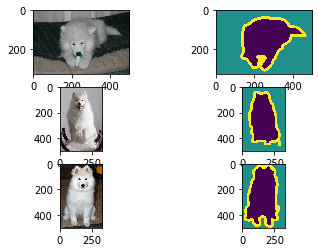

In [110]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2)

axs[0, 0].imshow(img1)
axs[0, 1].imshow(seg1)
axs[1, 0].imshow(img2)
axs[1, 1].imshow(seg2)
axs[2, 0].imshow(img3)
axs[2, 1].imshow(seg3)

Groundtruth masks are **trimaps** with regions corresponding to: pet body (label 1), background (label 2) and ambiguous (pet body boundaries and/or any accessory such as collars) areas (label 3)

The function provided below list all the files in the *path* folder (except hidden files).

In [111]:
import numpy as np
import os
def listdir_nohidden(path):
    l = []
    for f in np.sort(os.listdir(path)) :
        if f.startswith('.') == False :
            l.append(f)
    return l

**Question 2 -** Store images and associated masks in single array structures (**imgs** and **segs**) after 64$\times$64 reshaping for further deep learning processing. Background and ambiguous areas will be labeled as 0, pet body regions at 1.

In [112]:
from skimage.transform import resize

size_ = 64
list_ = listdir_nohidden(folder_img)
list_seg = listdir_nohidden(folder_seg)
imgs = np.ndarray((len(list_), size_, size_, 3), dtype=np.float32)
segs = np.ndarray((len(list_), size_, size_, 1), dtype=np.uint8)
idxs = []

In [113]:
for idx, id_ in enumerate(list_):
    name = id_.split('.')[0]
    img = io.imread(folder_img+id_)
    seg = io.imread(folder_seg+list_seg[idx])
    imgs[idx,:,:,:] = resize(img,mode='reflect',preserve_range=True, output_shape=(size_, size_))
    segs[idx,:,:,0] = resize(seg,mode='reflect',preserve_range=True,anti_aliasing_sigma=3, output_shape=(size_, size_)).astype(np.uint8)
    segs[idx,:,:,0] = np.where(segs[idx,:,:,0]>1, 0, segs[idx,:,:,0]) # background/ambiguous areas at 0, pet body regions at 1
    idxs.append(name)

**Question 3 -** Implement and apply a function **normalization()** which standardizes the dataset (center to the mean and component wise scale to unit variance).

In [114]:
def normalization(imgs):
    imgs = imgs.astype('float32', copy=False)
    for idx, img in enumerate(imgs):
        mean_ = np.mean(img)
        variance = np.var(img)
        img = (img-mean_)/np.sqrt(variance)
        imgs[idx] = img

normalization(imgs)  

Let us display the first four images with associated groundtruth masks.

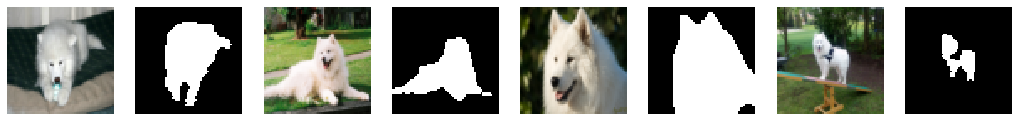

In [115]:
from skimage.exposure import rescale_intensity

plt.figure(figsize=(18, 4))
plt.subplot(181)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[0], in_range=(np.min(imgs[0]),np.max(imgs[0])), out_range=(0,1)))
plt.subplot(182)
plt.axis('off')
plt.imshow(segs[0,:,:,0], cmap='gray')
plt.subplot(183)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[1], in_range=(np.min(imgs[1]),np.max(imgs[1])), out_range=(0,1)))
plt.subplot(184)
plt.axis('off')
plt.imshow(segs[1,:,:,0], cmap='gray')
plt.subplot(185)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[2], in_range=(np.min(imgs[2]),np.max(imgs[2])), out_range=(0,1)))
plt.subplot(186)
plt.axis('off')
plt.imshow(segs[2,:,:,0], cmap='gray')
plt.subplot(187)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[3], in_range=(np.min(imgs[3]),np.max(imgs[3])), out_range=(0,1)))
plt.subplot(188)
plt.axis('off')
plt.imshow(segs[3,:,:,0], cmap='gray')
plt.show()

**Question 4 -** Divide the dataset into 2 subsets. The first 80% will belong to the training set, the last 20% to the test set.

In [116]:
ratio = 0.8
split = np.int(len(imgs)*ratio)
train_imgs = imgs[0:split] # training images
train_segs = segs[0:split] # training segmentation masks
test_imgs = imgs[split::] # test images
test_segs = segs[split::] # test segmentation masks
train_idxs = list_[0:split] # training image ids
test_idxs = list_[split::]# test image ids

for idx, string_ in enumerate(train_idxs):
    train_idxs[idx] = string_.split('_')[-1].split('.')[0]
    
for idx, string_ in enumerate(test_idxs):
    test_idxs[idx] = string_.split('_')[-1].split('.')[0]

The functions provided below aims at computing the dice score which will be used as loss function in our deep learning networks. 

In [117]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Rather than extracting individual patches from the image and classifying these patches independently, we will first employ a stack of convolutional layers preserving the spatial size of the input --> **Fully Convolutional Networks** (FCN).

**Question 5 -** Implement a FCN network with 7 convolutional layers: 2 with 32 3x3 filters and Rectified Linear Unit (ReLU) activation, 2 with 64 3x3 filters and ReLU activation, 2 with 128 3x3 filters and ReLU activation as well as a final 1x1 convolutional layer with sigmoid activation to achieve pixel-wise segmentation.

In [136]:
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras import backend as K

def get_model_1(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
    
    conv7 = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer = 'he_normal')(conv6)

    model = Model(inputs=[inputs], outputs=[conv7])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

Let us now display the network architecture (with **model.summary()**), define the batch size and the number of epochs, defined the model checkpoint (https://keras.io/callbacks/), run the training (with **model.fit()**) and display how the dice score evolves during training for both training and test datasets.

In [137]:
model_1 = get_model_1(size_, size_)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 64, 64, 128)       147584    
__________

In [138]:
batch_size = 10
epochs = 200

In [139]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

Using the option **save_best_only=True**, the latest best model according to the quantity monitored (**val_dice_coef**) will not be overwritten.

In [140]:
hist_1 = model_1.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

Train on 160 samples, validate on 40 samples
Epoch 1/200
160/160 [==============================] - 2s 10ms/step - loss: -0.5630 - dice_coef: 0.5630 - val_loss: -0.6478 - val_dice_coef: 0.6478
Epoch 2/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6303 - dice_coef: 0.6303 - val_loss: -0.6558 - val_dice_coef: 0.6558
Epoch 3/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6590 - dice_coef: 0.6590 - val_loss: -0.6583 - val_dice_coef: 0.6583
Epoch 4/200
160/160 [==============================] - 0s 1ms/step - loss: -0.6697 - dice_coef: 0.6697 - val_loss: -0.6769 - val_dice_coef: 0.6769
Epoch 5/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6868 - dice_coef: 0.6868 - val_loss: -0.6671 - val_dice_coef: 0.6671
Epoch 6/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6930 - dice_coef: 0.6930 - val_loss: -0.6770 - val_dice_coef: 0.6770
Epoch 7/200
160/160 [==============================] - 0s 2ms/step - los

160/160 [==============================] - 0s 2ms/step - loss: -0.8332 - dice_coef: 0.8332 - val_loss: -0.7761 - val_dice_coef: 0.7761
Epoch 112/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8333 - dice_coef: 0.8333 - val_loss: -0.7557 - val_dice_coef: 0.7557
Epoch 113/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8232 - dice_coef: 0.8232 - val_loss: -0.7769 - val_dice_coef: 0.7769
Epoch 114/200
160/160 [==============================] - 0s 1ms/step - loss: -0.8224 - dice_coef: 0.8224 - val_loss: -0.7724 - val_dice_coef: 0.7724
Epoch 115/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8283 - dice_coef: 0.8283 - val_loss: -0.7747 - val_dice_coef: 0.7747
Epoch 116/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8344 - dice_coef: 0.8344 - val_loss: -0.7647 - val_dice_coef: 0.7647
Epoch 117/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8304 - dice_coef: 0.8304 - val_loss: -0.

160/160 [==============================] - 0s 2ms/step - loss: -0.8463 - dice_coef: 0.8463 - val_loss: -0.7776 - val_dice_coef: 0.7776
Epoch 167/200
160/160 [==============================] - 0s 1ms/step - loss: -0.8488 - dice_coef: 0.8488 - val_loss: -0.7800 - val_dice_coef: 0.7800
Epoch 168/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8496 - dice_coef: 0.8496 - val_loss: -0.7769 - val_dice_coef: 0.7769
Epoch 169/200
160/160 [==============================] - 0s 1ms/step - loss: -0.8469 - dice_coef: 0.8469 - val_loss: -0.7909 - val_dice_coef: 0.7909
Epoch 170/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8473 - dice_coef: 0.8473 - val_loss: -0.7779 - val_dice_coef: 0.7779
Epoch 171/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8439 - dice_coef: 0.8439 - val_loss: -0.7812 - val_dice_coef: 0.7812
Epoch 172/200
160/160 [==============================] - 0s 2ms/step - loss: -0.8508 - dice_coef: 0.8508 - val_loss: -0.

In [141]:
def display_history(hist):
    plt.plot(hist.history['dice_coef'])
    plt.plot(hist.history['val_dice_coef'])
    plt.title('model loss')
    plt.ylabel('dice')
    plt.ylim([0,1])     
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

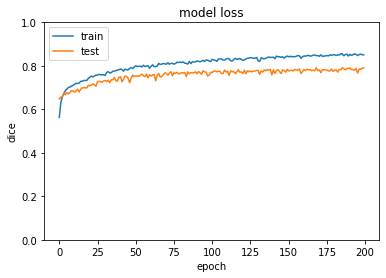

In [142]:
display_history(hist_1)

In [143]:
def dice_assessment(result, GT, label=1):
    A = GT == label
    B = result == label            
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    TN = len(np.nonzero((~A)*(~B))[0])
    dice = 0
    if (FP+2*TP+FN) != 0 : 
        dice = float(2)*TP/(FP+2*TP+FN)
    return dice

In [144]:
from skimage.segmentation import mark_boundaries

def visualize_predicted_boundary(img, pred, groundtruth):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    out = mark_boundaries(img, groundtruth, color=(0, 1, 0), background_label=4)
    out = mark_boundaries(out, pred, color=(1, 0, 0), background_label=2)
    return out

**Question 6 -** Using the provided **dice_assessment()** and **visualize_predicted_boundary()** functions to be read and understood, implement and apply **make_prediction()** to provide for each test image the predicted segmentation mask as well as the dice score. Dice scores will be stored in the array **dices**. What is the average dice score obtained for the test set?

In [145]:
from skimage.color import rgb2gray

def make_prediction(model, test_idxs, test_imgs, test_segs, folder = './weights.hdf5'):
    dices = []
    model.load_weights(folder)
    for idx, id_ in enumerate(test_idxs):
        pred = model.predict(test_imgs[idx:idx+1,:,:,:])[0,:,:,0].astype(np.uint8) # prediction
        groundtruth = test_segs[idx,:,:,0]
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.axis('off')
        plt.imshow(rescale_intensity(test_imgs[idx], in_range=(np.min(test_imgs[idx]),np.max(test_imgs[idx])), out_range=(0,1)))
        plt.subplot(132)
        plt.axis('off')
        plt.imshow(pred, cmap='gray')
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(visualize_predicted_boundary(test_imgs[idx,:,:,:], pred, groundtruth)) # image with super-imposed prediction and groundruth 
        plt.show()
        dice = dice_assessment(pred, groundtruth, label=1)
        print(id_, 'dice :',dice)
        dices.append(dice)
    return np.array(dices)

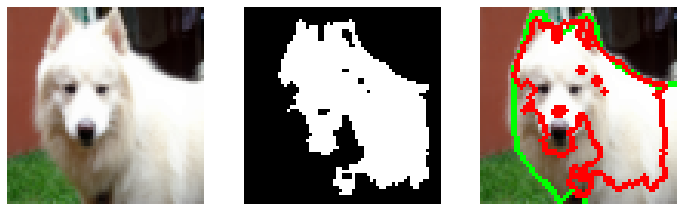

samoyed_63.jpg dice : 0.7777506708953403


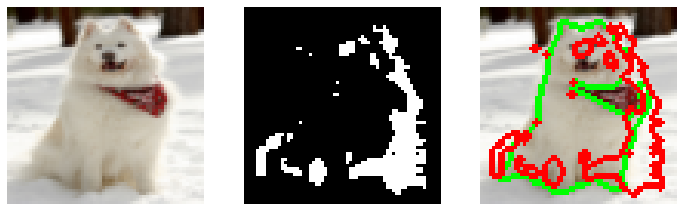

samoyed_64.jpg dice : 0.24053030303030304


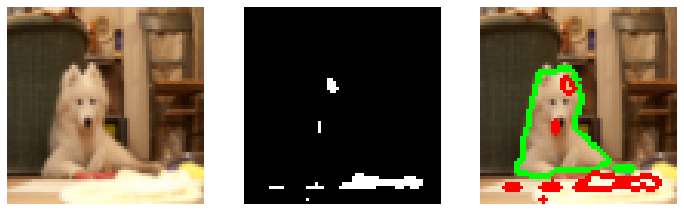

samoyed_65.jpg dice : 0.04918032786885246


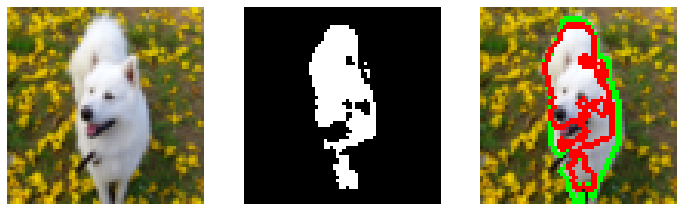

samoyed_66.jpg dice : 0.7762148337595908


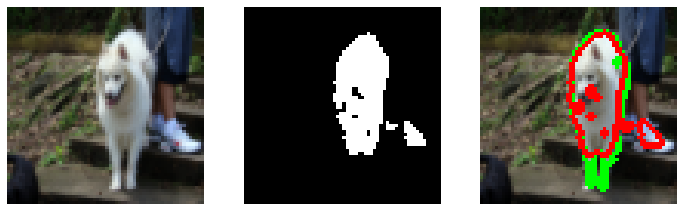

samoyed_67.jpg dice : 0.8458225667527993


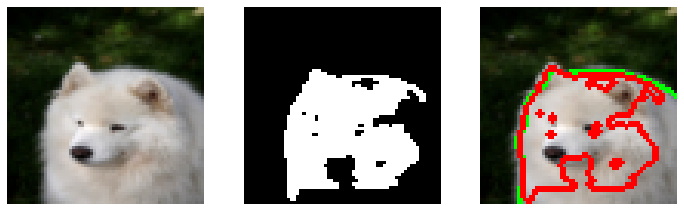

samoyed_68.jpg dice : 0.7592033796016898


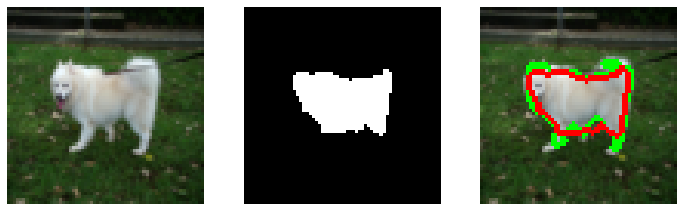

samoyed_69.jpg dice : 0.8959854014598541


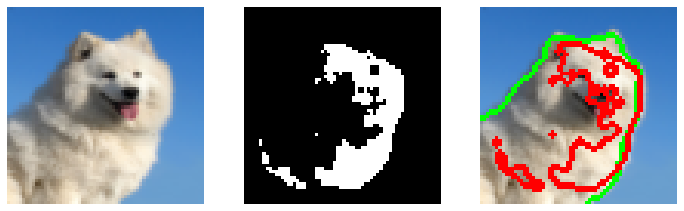

samoyed_7.jpg dice : 0.4664804469273743


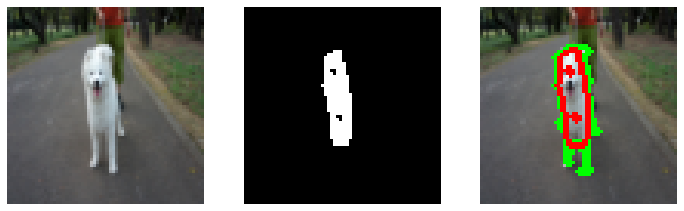

samoyed_70.jpg dice : 0.7806691449814126


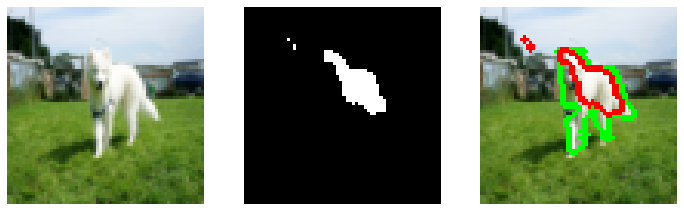

samoyed_71.jpg dice : 0.602291325695581


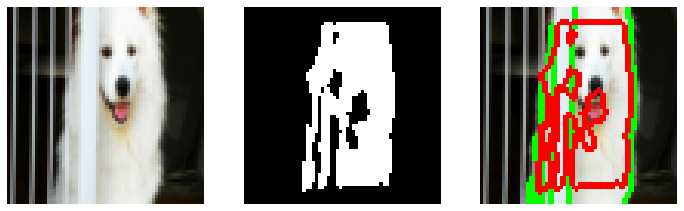

samoyed_72.jpg dice : 0.7292143401983219


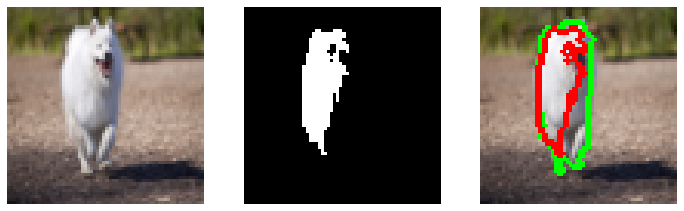

samoyed_73.jpg dice : 0.7171239356669821


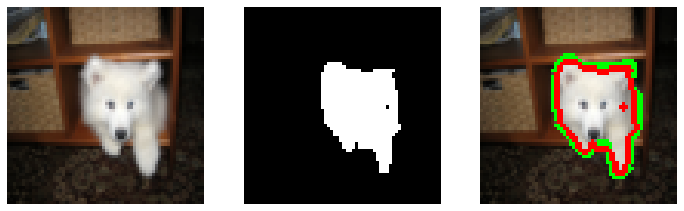

samoyed_74.jpg dice : 0.8962536023054755


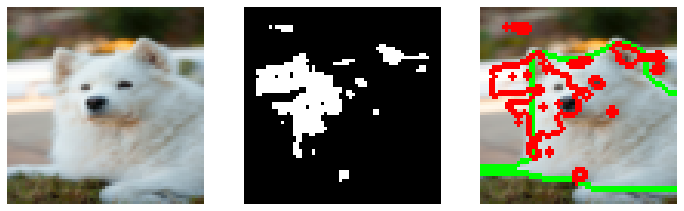

samoyed_75.jpg dice : 0.2825040128410915


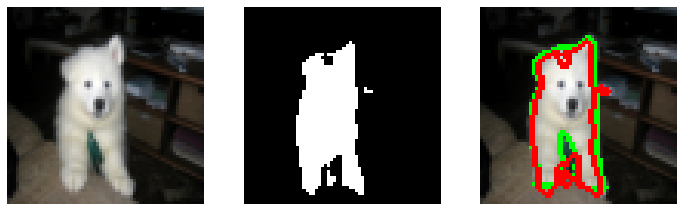

samoyed_76.jpg dice : 0.8828715365239295


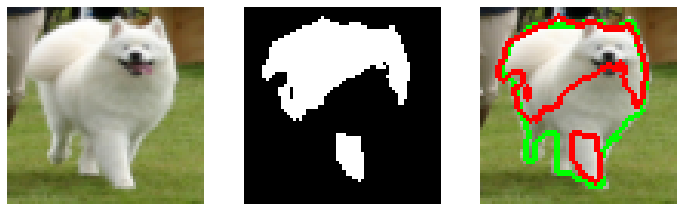

samoyed_77.jpg dice : 0.7290969899665551


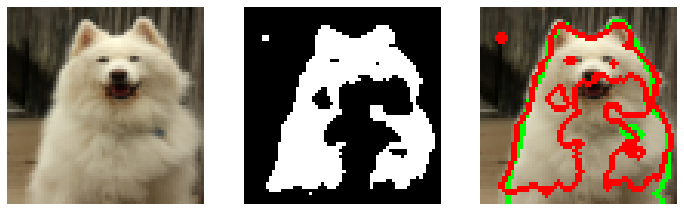

samoyed_78.jpg dice : 0.7238648363252376


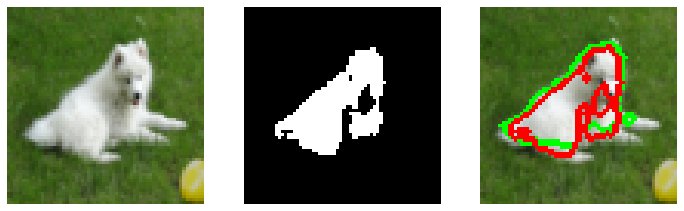

samoyed_79.jpg dice : 0.8183183183183184


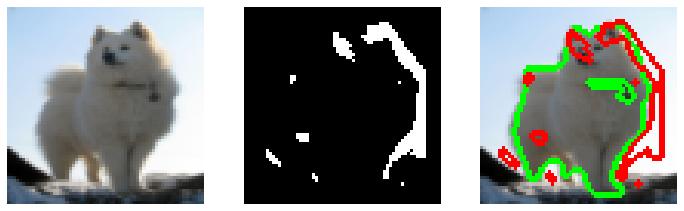

samoyed_8.jpg dice : 0.11571125265392782


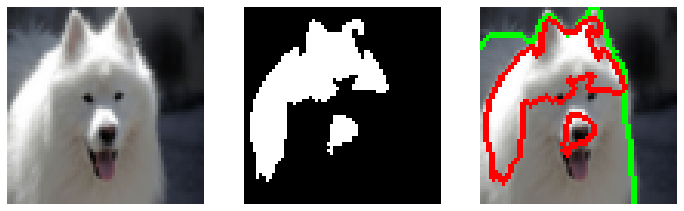

samoyed_80.jpg dice : 0.5330781848004374


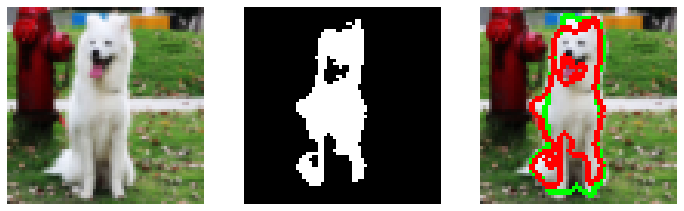

samoyed_81.jpg dice : 0.8165965123271197


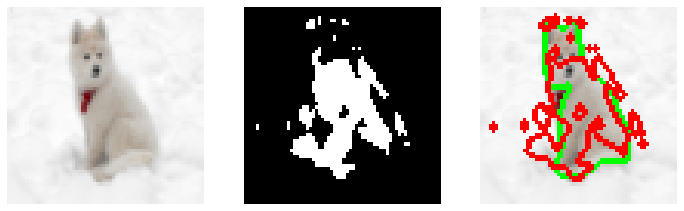

samoyed_82.jpg dice : 0.6525479814692257


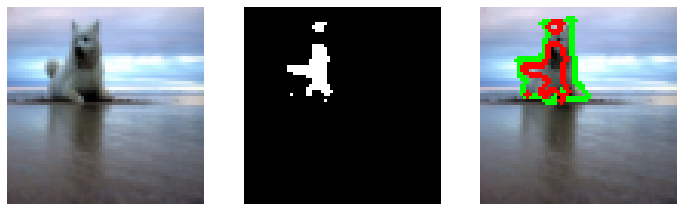

samoyed_83.jpg dice : 0.5319148936170213


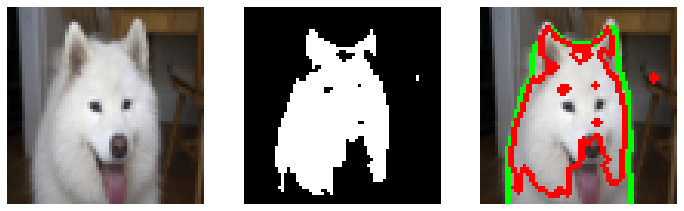

samoyed_84.jpg dice : 0.8021525799303577


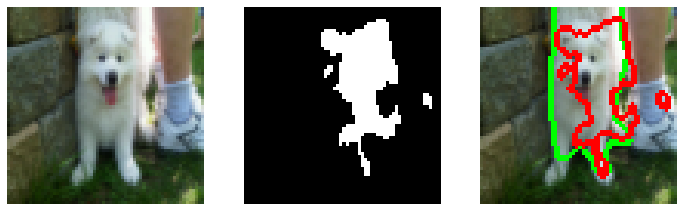

samoyed_85.jpg dice : 0.6585648148148148


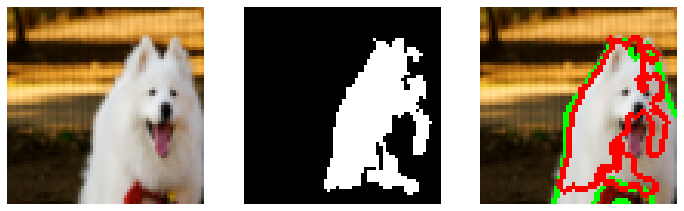

samoyed_86.jpg dice : 0.7581227436823105


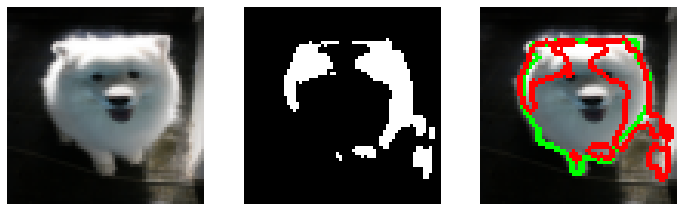

samoyed_87.jpg dice : 0.48865435356200526


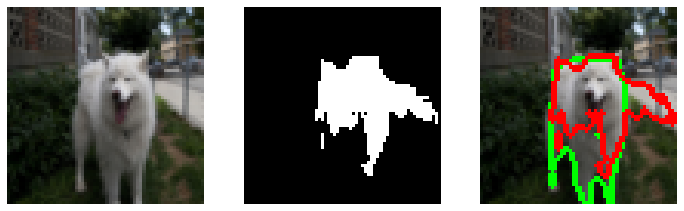

samoyed_88.jpg dice : 0.6971279373368147


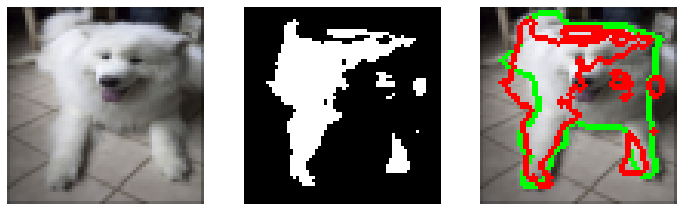

samoyed_89.jpg dice : 0.6241610738255033


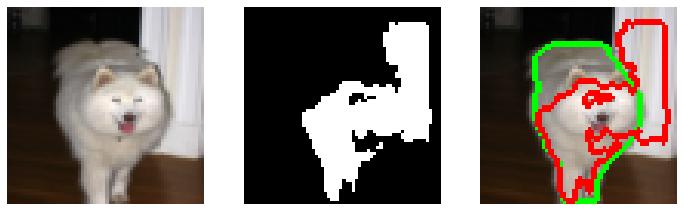

samoyed_9.jpg dice : 0.5826972010178118


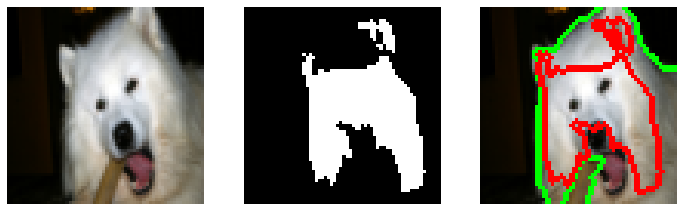

samoyed_90.jpg dice : 0.6416499570323689


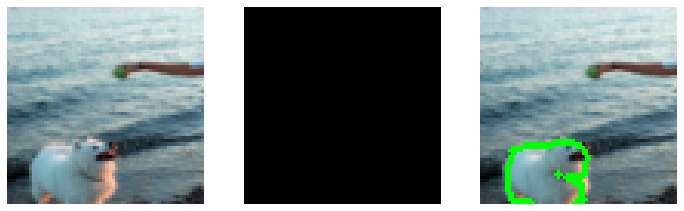

samoyed_91.jpg dice : 0.0


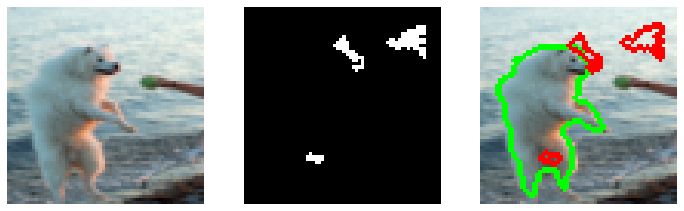

samoyed_92.jpg dice : 0.03361344537815126


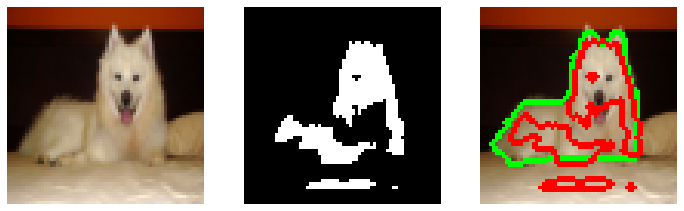

samoyed_93.jpg dice : 0.644122383252818


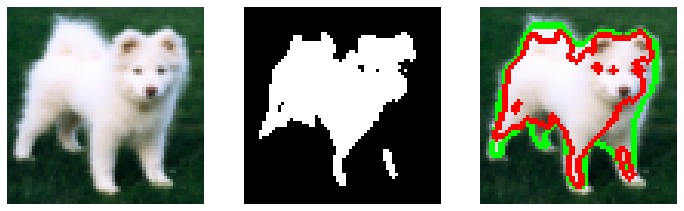

samoyed_94.jpg dice : 0.845506563446651


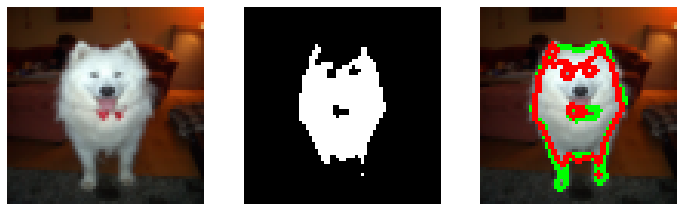

samoyed_95.jpg dice : 0.8697318007662835


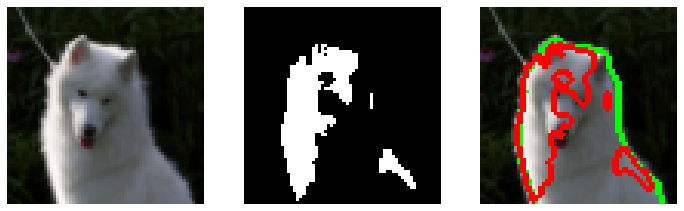

samoyed_96.jpg dice : 0.552308343922067


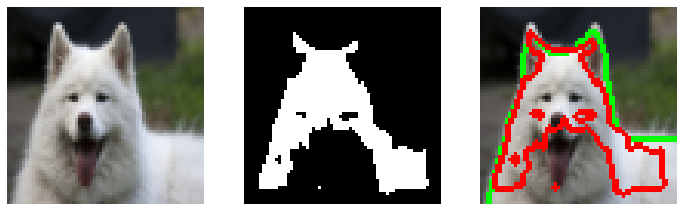

samoyed_97.jpg dice : 0.662986813860779


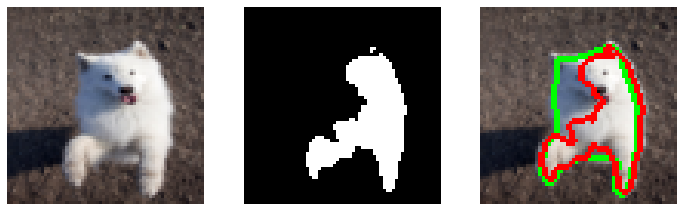

samoyed_98.jpg dice : 0.7666466706658668


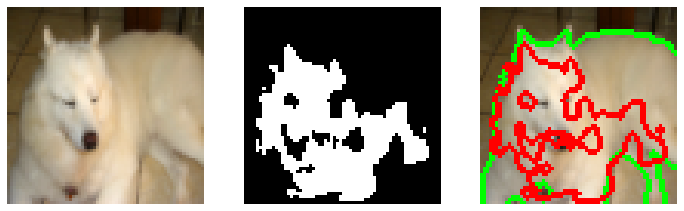

samoyed_99.jpg dice : 0.6099358212502971
average dice: 0.6215301825432835


In [146]:
import os

dices_1 = make_prediction(model_1, test_idxs, test_imgs, test_segs)
print('average dice:', np.mean(np.array(dices_1)))
os.remove('./weights.hdf5')

Better deep learning networks can be reached using some downsampling and upsampling operations.

**Question 7 -** Implement a new network consisting of patterns of 2 convolutional layers followed by a pooling (resp. upsampling) layer for encoding (decoding) branches using **MaxPooling2D** (**Conv2DTranspose**). Convolutional layers will exploit 3x3 filters followed by ReLU activations. Spatial size will be reduced (increased) with 2×2 max pooling (upsampling) layers. The 2 first convolutional layer will generate 32 channels. This number will double after each pattern.

In [147]:
from keras.layers import MaxPooling2D, Conv2DTranspose
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras import backend as K


def get_model_2(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)

    up4 = Conv2DTranspose(filters=64,kernel_size=(2,2), strides=(2,2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

    up5 = Conv2DTranspose(filters=32,kernel_size=(2,2),strides=(2,2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer = 'he_normal')(conv5)

    model = Model(inputs=[inputs], outputs=[conv6])
    if prediction_weights != None:
        model.load_weights(prediction_weights)
        
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [148]:
model_checkpoint = ModelCheckpoint('./weights2.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

**Question 8 -** Run the training and use **make_prediction()** to provide predicted segmentation masks. What is the average dice score obtained for the test set?

In [149]:
size_ = 64

model_2 = get_model_2(size_, size_)
model_2.summary()
hist_2 = model_2.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
__________

160/160 [==============================] - 0s 1ms/step - loss: -0.9204 - dice_coef: 0.9204 - val_loss: -0.7919 - val_dice_coef: 0.7919
Epoch 95/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9225 - dice_coef: 0.9225 - val_loss: -0.8083 - val_dice_coef: 0.8083
Epoch 96/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9213 - dice_coef: 0.9213 - val_loss: -0.7926 - val_dice_coef: 0.7926
Epoch 97/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9262 - dice_coef: 0.9262 - val_loss: -0.8070 - val_dice_coef: 0.8070
Epoch 98/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9278 - dice_coef: 0.9278 - val_loss: -0.8007 - val_dice_coef: 0.8007
Epoch 99/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9240 - dice_coef: 0.9240 - val_loss: -0.8126 - val_dice_coef: 0.8126
Epoch 100/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9278 - dice_coef: 0.9278 - val_loss: -0.8030 

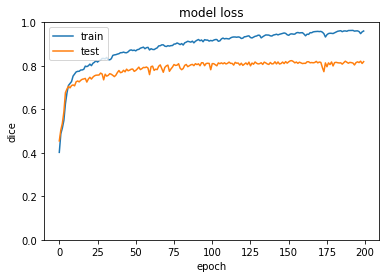

In [71]:
display_history(hist_2)

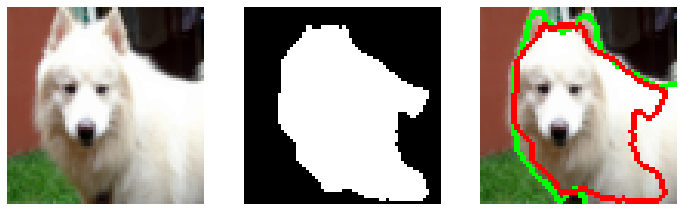

samoyed_63.jpg dice : 0.8620925461591065


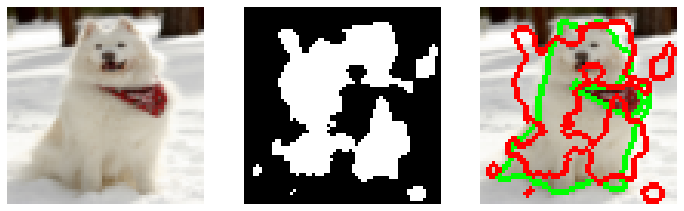

samoyed_64.jpg dice : 0.6761710794297352


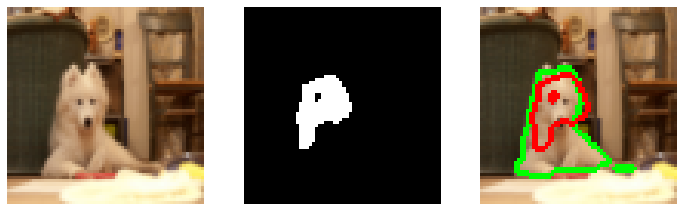

samoyed_65.jpg dice : 0.5350172215843858


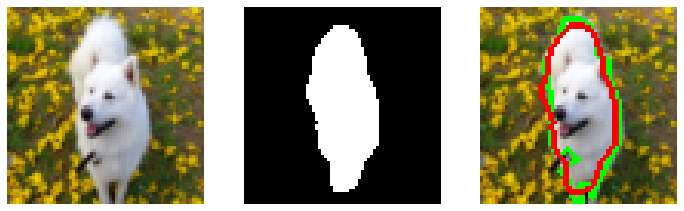

samoyed_66.jpg dice : 0.9149051490514906


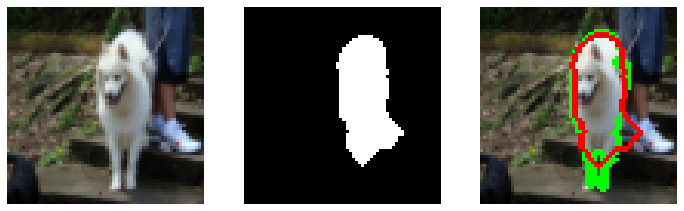

samoyed_67.jpg dice : 0.8675496688741722


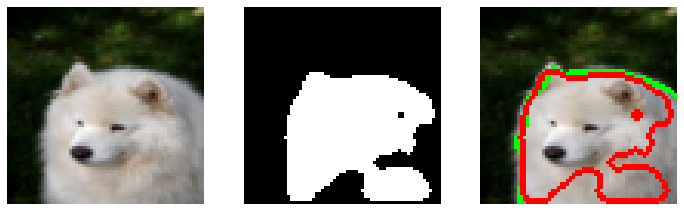

samoyed_68.jpg dice : 0.8539576365663322


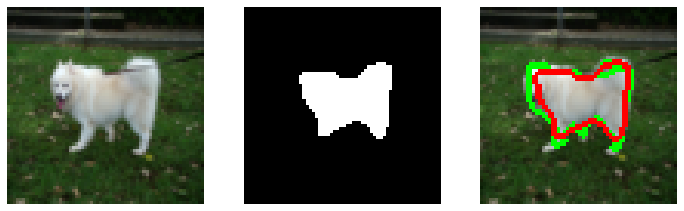

samoyed_69.jpg dice : 0.8801463860933212


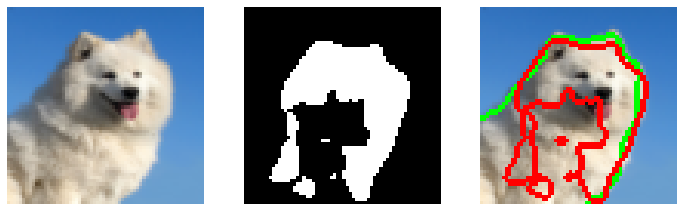

samoyed_7.jpg dice : 0.6528528528528529


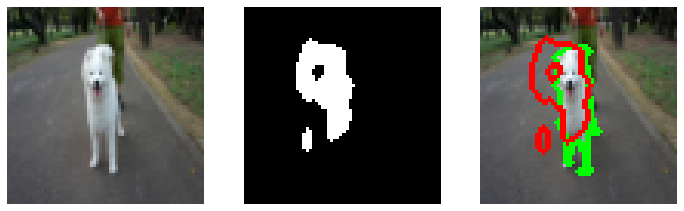

samoyed_70.jpg dice : 0.6426592797783933


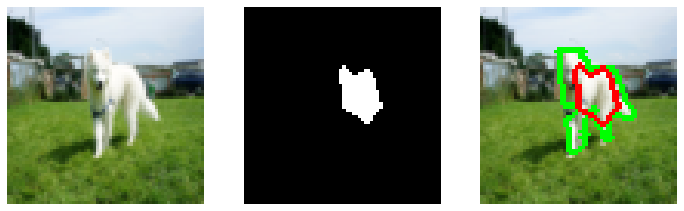

samoyed_71.jpg dice : 0.5766666666666667


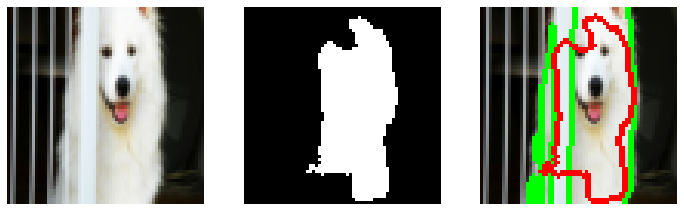

samoyed_72.jpg dice : 0.7172897196261683


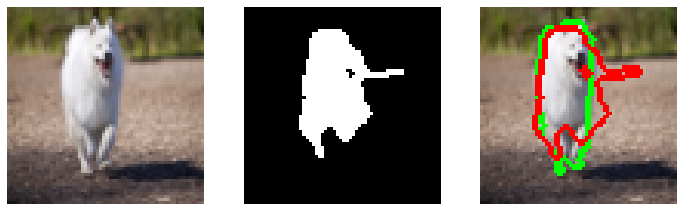

samoyed_73.jpg dice : 0.7967479674796748


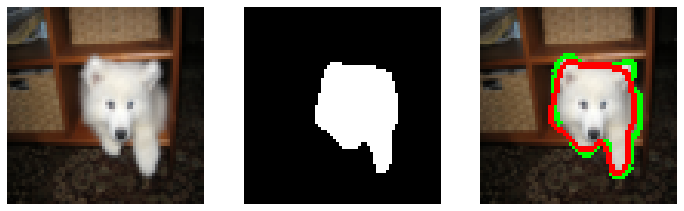

samoyed_74.jpg dice : 0.9107519325368939


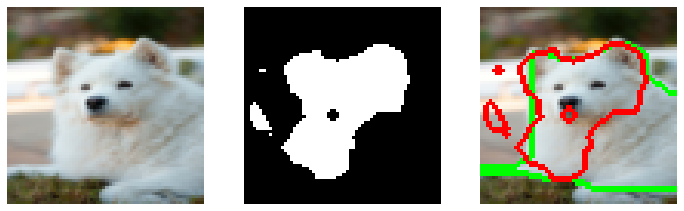

samoyed_75.jpg dice : 0.667953667953668


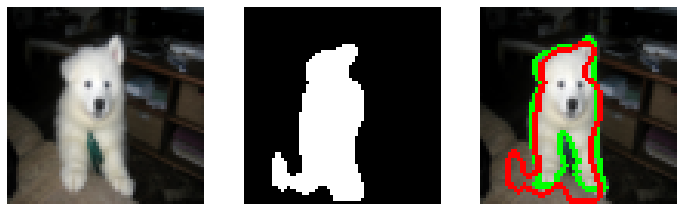

samoyed_76.jpg dice : 0.8065984072810012


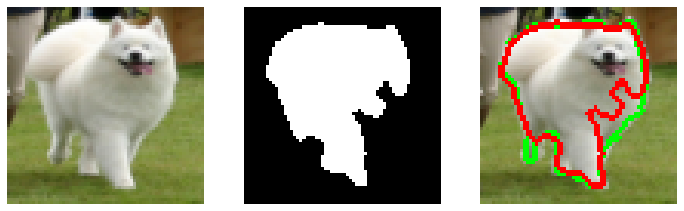

samoyed_77.jpg dice : 0.9236111111111112


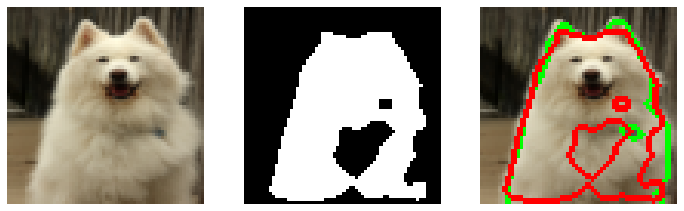

samoyed_78.jpg dice : 0.8672189349112426


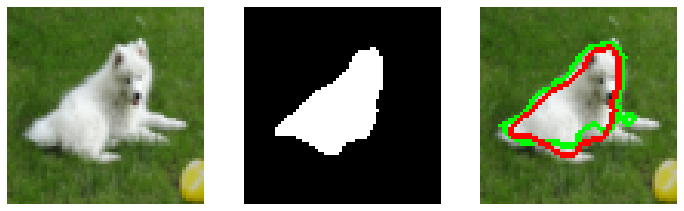

samoyed_79.jpg dice : 0.8504741064916119


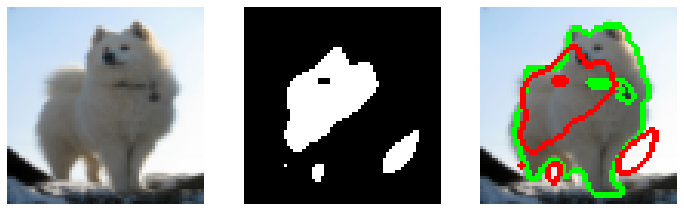

samoyed_8.jpg dice : 0.4920494699646643


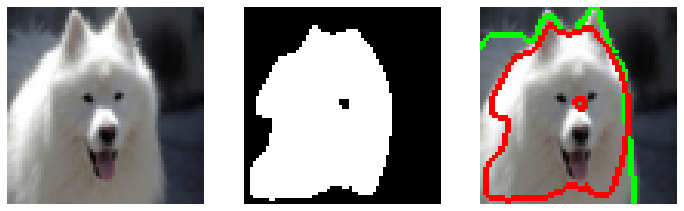

samoyed_80.jpg dice : 0.8471092077087794


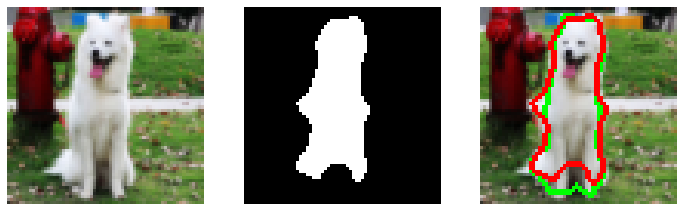

samoyed_81.jpg dice : 0.8981380065717415


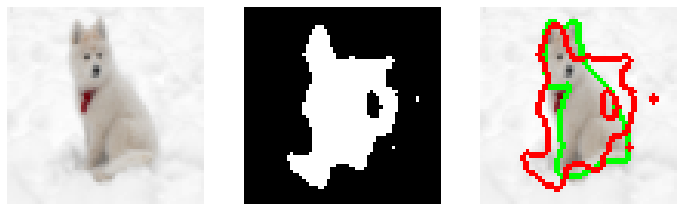

samoyed_82.jpg dice : 0.6937877954920286


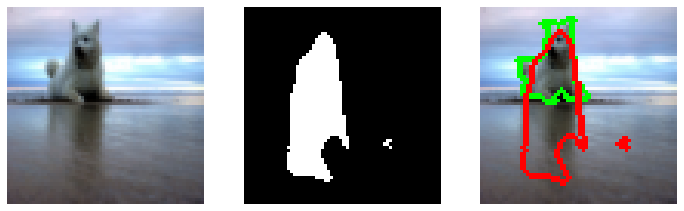

samoyed_83.jpg dice : 0.49796747967479676


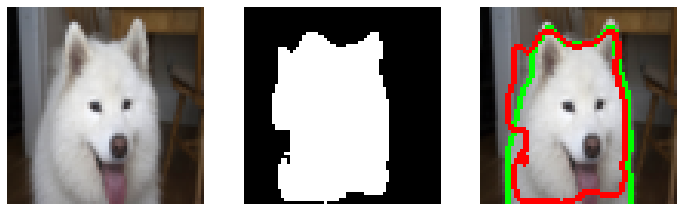

samoyed_84.jpg dice : 0.897568970226714


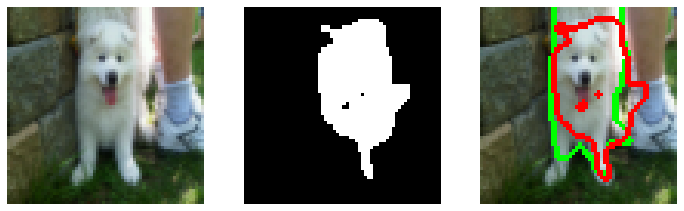

samoyed_85.jpg dice : 0.7951807228915663


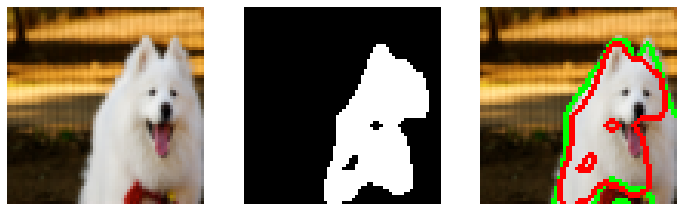

samoyed_86.jpg dice : 0.80234375


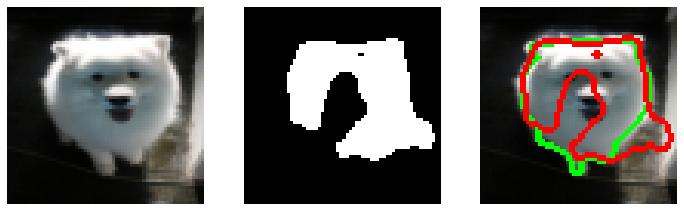

samoyed_87.jpg dice : 0.784507622579316


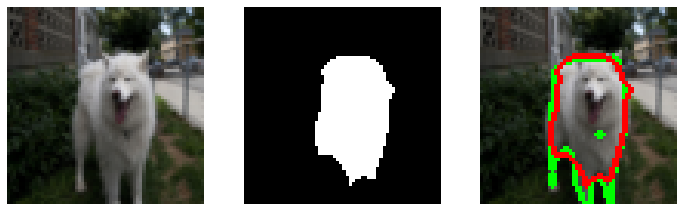

samoyed_88.jpg dice : 0.9214850882531954


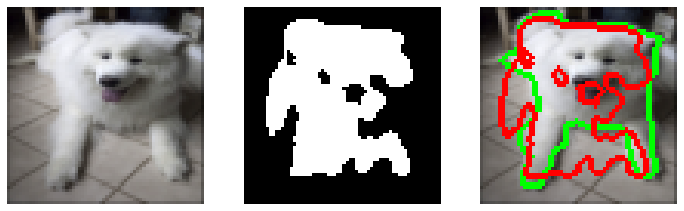

samoyed_89.jpg dice : 0.7182089552238806


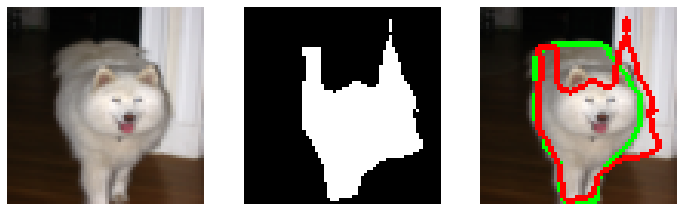

samoyed_9.jpg dice : 0.7862753203803224


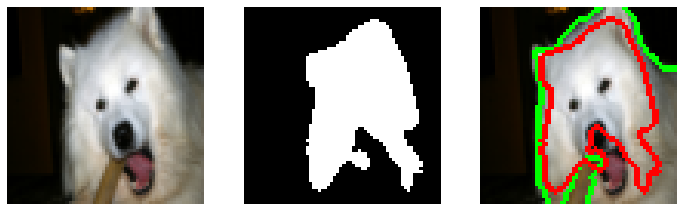

samoyed_90.jpg dice : 0.7352239597137556


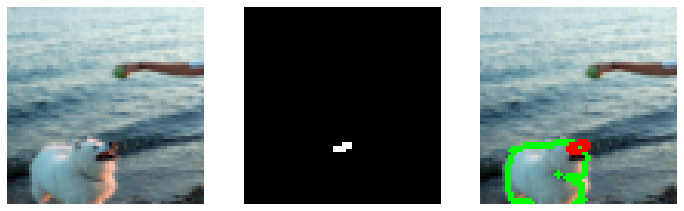

samoyed_91.jpg dice : 0.035164835164835165


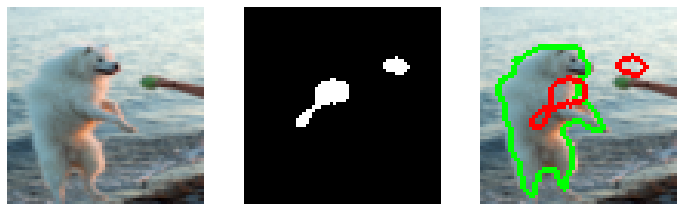

samoyed_92.jpg dice : 0.16743330266789327


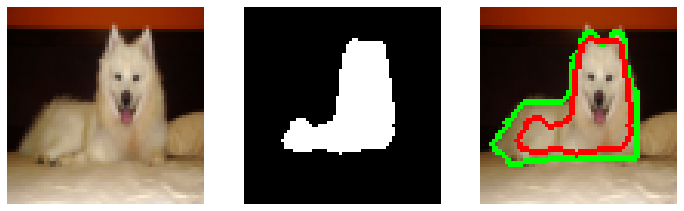

samoyed_93.jpg dice : 0.7787610619469026


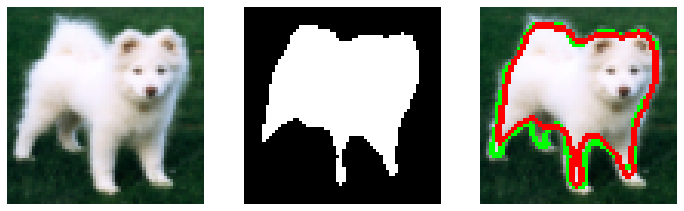

samoyed_94.jpg dice : 0.9388753056234719


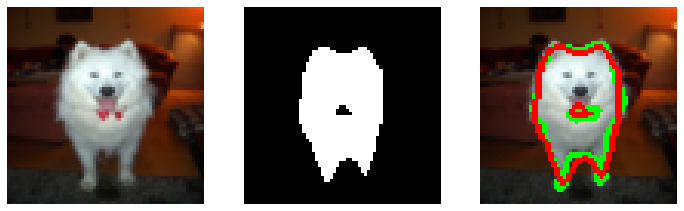

samoyed_95.jpg dice : 0.9144811858608894


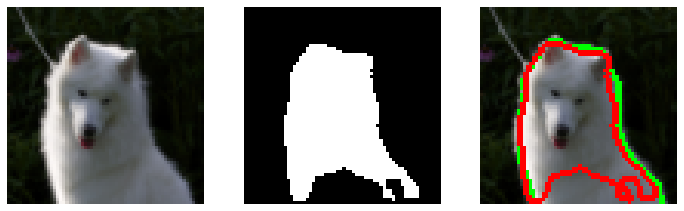

samoyed_96.jpg dice : 0.8687872763419483


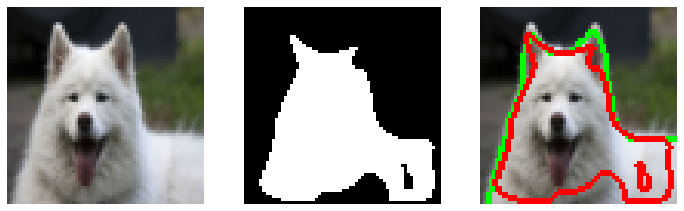

samoyed_97.jpg dice : 0.8867297366402455


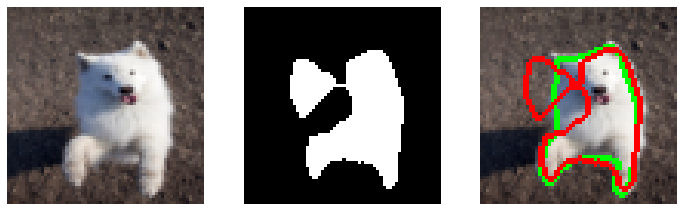

samoyed_98.jpg dice : 0.7862281603288798


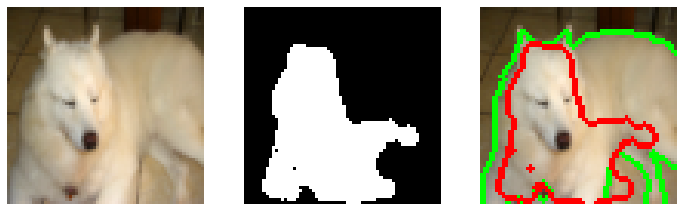

samoyed_99.jpg dice : 0.651685393258427
average dice: 0.7475164235240521


In [150]:
dices_2 = make_prediction(model_2, test_idxs, test_imgs, test_segs, folder='./weights2.hdf5')
print('average dice:', np.mean(np.array(dices_2)))
os.remove('./weights2.hdf5')

**Question 9 -** Add skip connections (i.e. feature concatenation from the encoder to the decoder) to the network implemented in question 7 using **concatenate**. Run the training, evaluate and comment on the reached segmentation accuracy (especially in comparison to model 2).

In [152]:
from keras.layers import concatenate

def get_model_3(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)

    up4 = Conv2DTranspose(filters=64,kernel_size=(2,2), strides=(2,2))(conv3)
    up4 = concatenate([up4,conv2],axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

    up5 = Conv2DTranspose(filters=32,kernel_size=(2,2),strides=(2,2))(conv4)
    up5 = concatenate([up5,conv1],axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer = 'he_normal')(conv5)    

    model = Model(inputs=[inputs], outputs=[conv6])
    if prediction_weights != None:
        model.load_weights(prediction_weights)
        
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [153]:
model_checkpoint = ModelCheckpoint('./weights3.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

In [154]:
model_3 = get_model_3(size_, size_)
model_3.summary()
hist_3 = model_3.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 64, 64, 32)   896         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 64, 64, 32)   9248        conv2d_146[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 32, 32, 32)   0           conv2d_147[0][0]                 
__________________________________________________________________________________________________
conv2d_148

160/160 [==============================] - 0s 1ms/step - loss: -0.9029 - dice_coef: 0.9029 - val_loss: -0.8068 - val_dice_coef: 0.8068
Epoch 83/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9067 - dice_coef: 0.9067 - val_loss: -0.8065 - val_dice_coef: 0.8065
Epoch 84/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9073 - dice_coef: 0.9073 - val_loss: -0.8098 - val_dice_coef: 0.8098
Epoch 85/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9094 - dice_coef: 0.9094 - val_loss: -0.8062 - val_dice_coef: 0.8062
Epoch 86/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9110 - dice_coef: 0.9110 - val_loss: -0.8131 - val_dice_coef: 0.8131
Epoch 87/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9096 - dice_coef: 0.9096 - val_loss: -0.8123 - val_dice_coef: 0.8123
Epoch 88/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9114 - dice_coef: 0.9114 - val_loss: -0.8084 -

160/160 [==============================] - 0s 1ms/step - loss: -0.9624 - dice_coef: 0.9624 - val_loss: -0.8059 - val_dice_coef: 0.8059
Epoch 193/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9621 - dice_coef: 0.9621 - val_loss: -0.8097 - val_dice_coef: 0.8097
Epoch 194/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9628 - dice_coef: 0.9628 - val_loss: -0.7970 - val_dice_coef: 0.7970
Epoch 195/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9614 - dice_coef: 0.9614 - val_loss: -0.8050 - val_dice_coef: 0.8050
Epoch 196/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9619 - dice_coef: 0.9619 - val_loss: -0.8104 - val_dice_coef: 0.8104
Epoch 197/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9636 - dice_coef: 0.9636 - val_loss: -0.8118 - val_dice_coef: 0.8118
Epoch 198/200
160/160 [==============================] - 0s 1ms/step - loss: -0.9631 - dice_coef: 0.9631 - val_loss: -0.

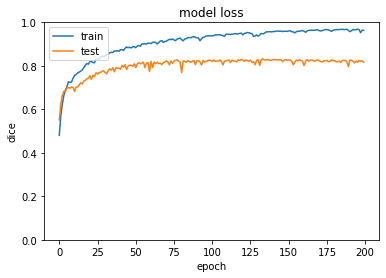

In [76]:
display_history(hist_3)

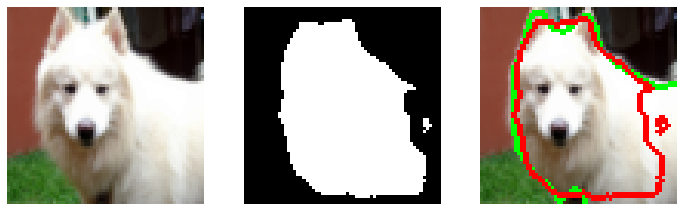

samoyed_63.jpg dice : 0.8906043228936921


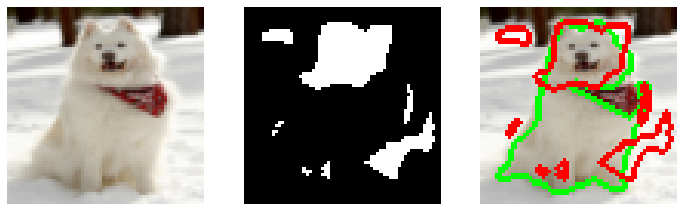

samoyed_64.jpg dice : 0.4373284537968893


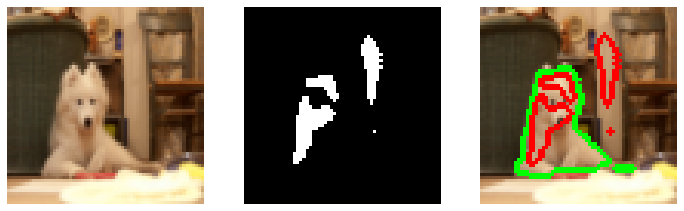

samoyed_65.jpg dice : 0.4067415730337079


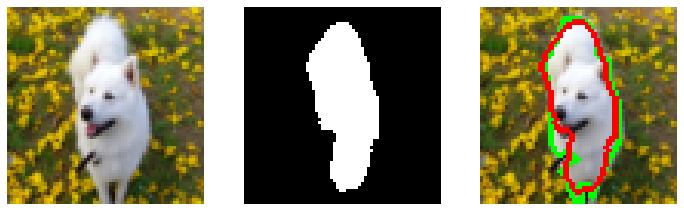

samoyed_66.jpg dice : 0.9110122358175751


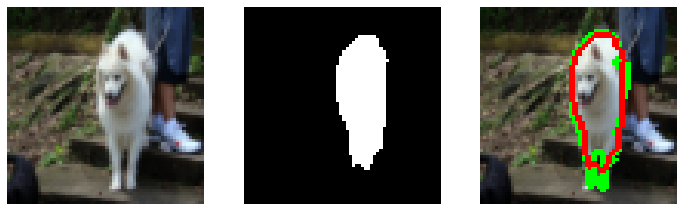

samoyed_67.jpg dice : 0.9026701119724375


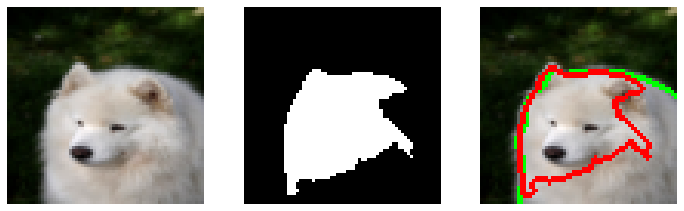

samoyed_68.jpg dice : 0.6758488148622678


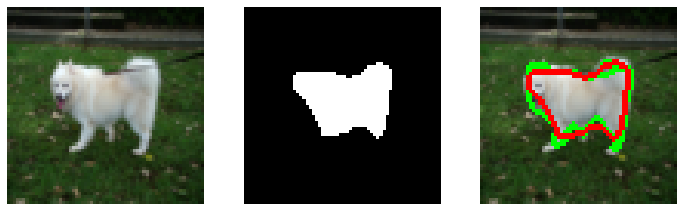

samoyed_69.jpg dice : 0.8890860692102928


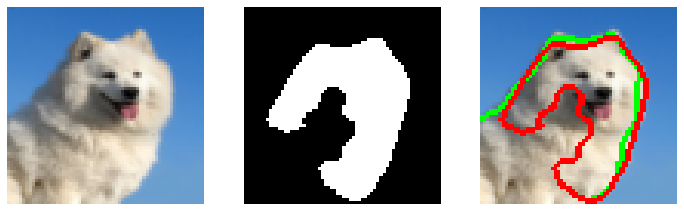

samoyed_7.jpg dice : 0.6920854997111496


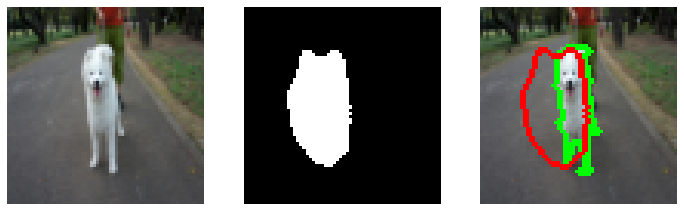

samoyed_70.jpg dice : 0.5262032085561498


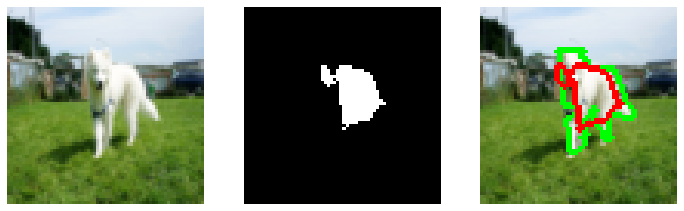

samoyed_71.jpg dice : 0.6605783866057838


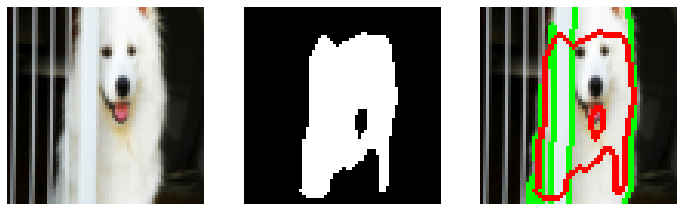

samoyed_72.jpg dice : 0.6726998491704375


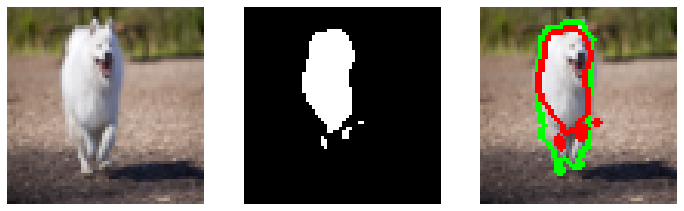

samoyed_73.jpg dice : 0.7877697841726619


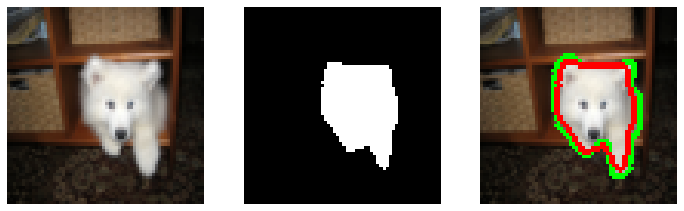

samoyed_74.jpg dice : 0.8929088277858177


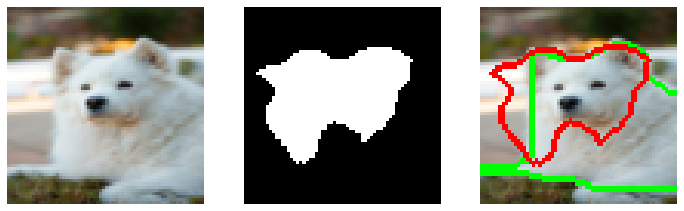

samoyed_75.jpg dice : 0.5800700413880929


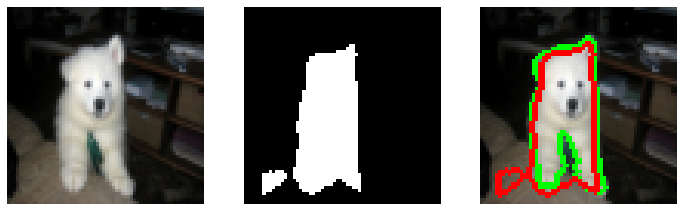

samoyed_76.jpg dice : 0.842603550295858


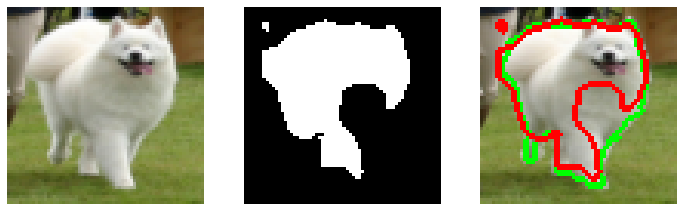

samoyed_77.jpg dice : 0.8516809492419248


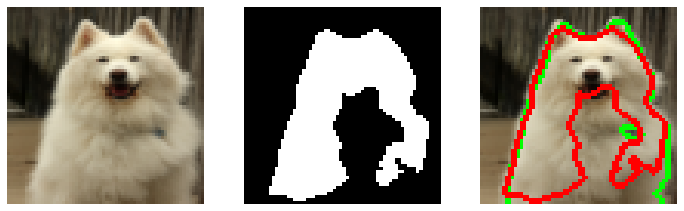

samoyed_78.jpg dice : 0.7819354838709678


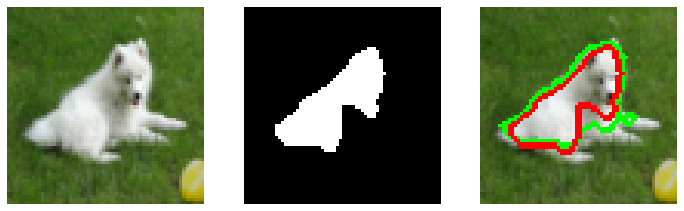

samoyed_79.jpg dice : 0.8427575522850503


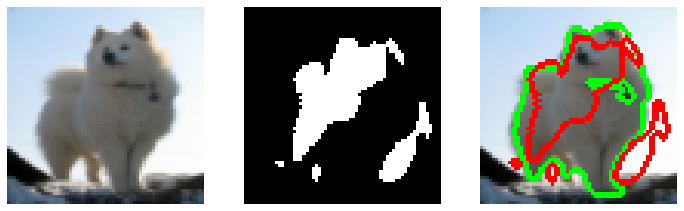

samoyed_8.jpg dice : 0.5233095338093238


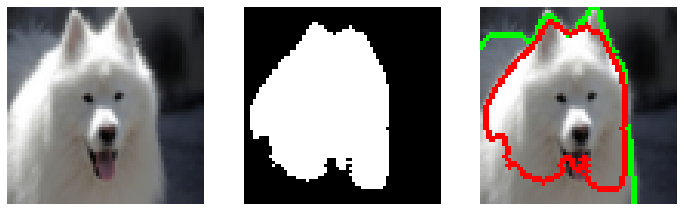

samoyed_80.jpg dice : 0.7933438272993029


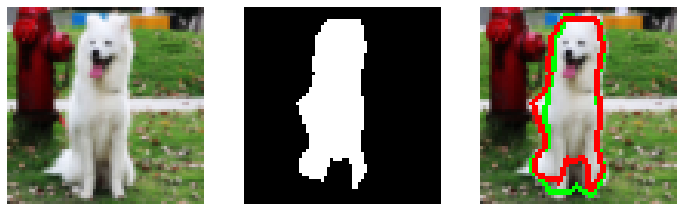

samoyed_81.jpg dice : 0.8901038819026791


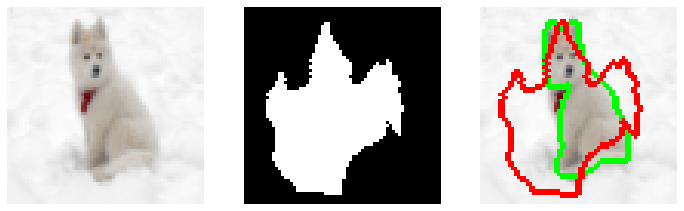

samoyed_82.jpg dice : 0.5740402193784278


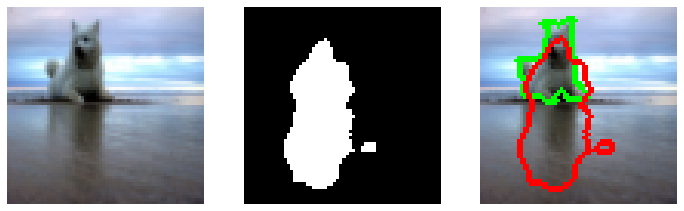

samoyed_83.jpg dice : 0.4098504837291117


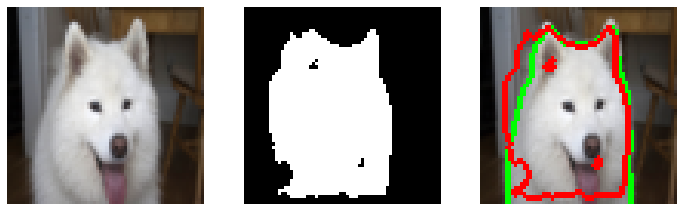

samoyed_84.jpg dice : 0.8873886038347286


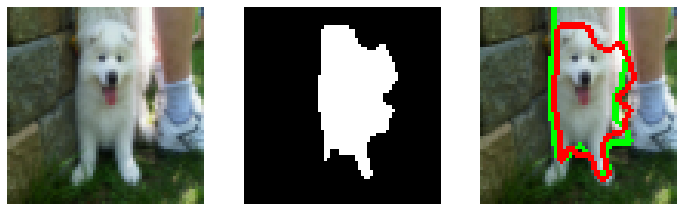

samoyed_85.jpg dice : 0.8076525336091003


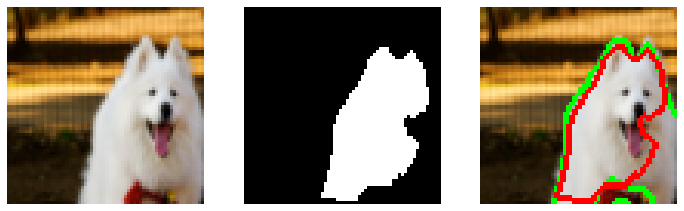

samoyed_86.jpg dice : 0.8263888888888888


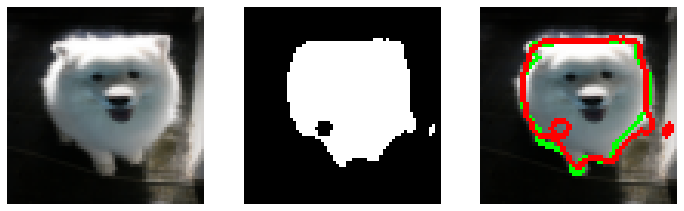

samoyed_87.jpg dice : 0.9391969407265774


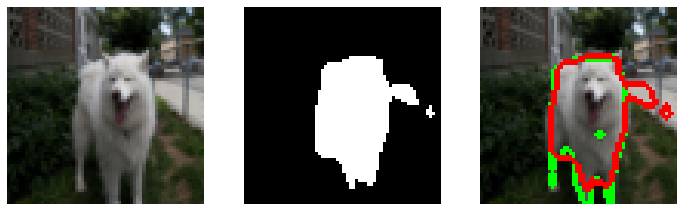

samoyed_88.jpg dice : 0.912463768115942


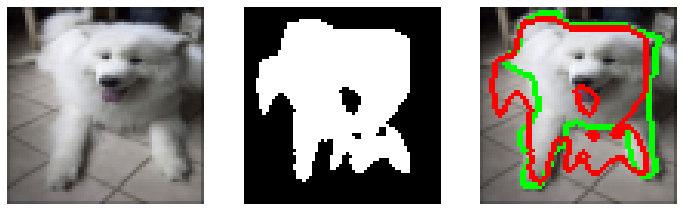

samoyed_89.jpg dice : 0.7907647907647908


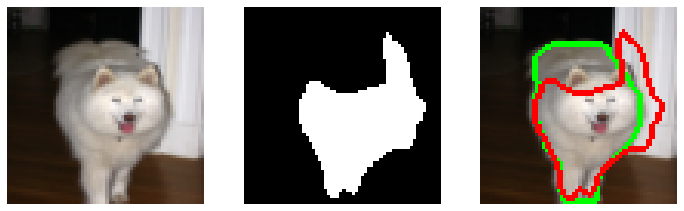

samoyed_9.jpg dice : 0.7285896889646357


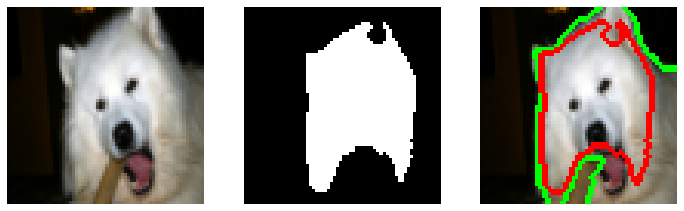

samoyed_90.jpg dice : 0.7494725738396625


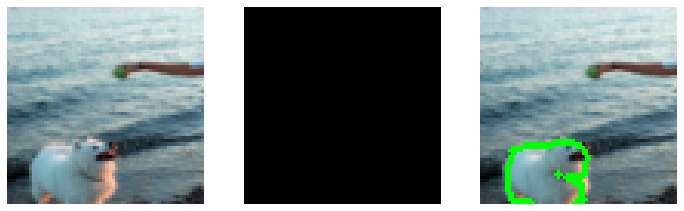

samoyed_91.jpg dice : 0.0


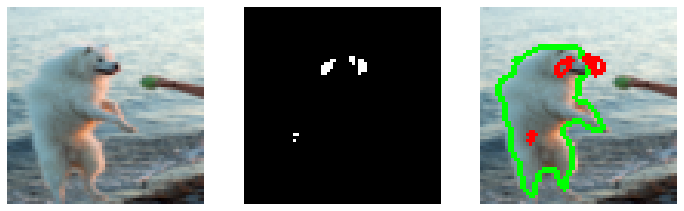

samoyed_92.jpg dice : 0.03458799593082401


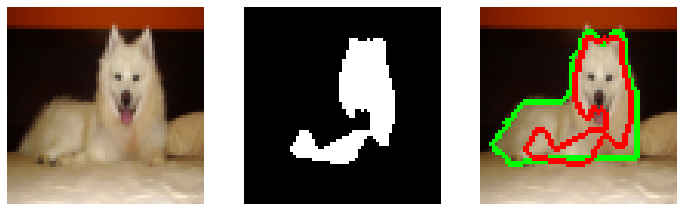

samoyed_93.jpg dice : 0.6554054054054054


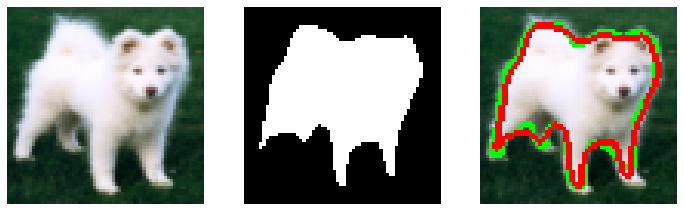

samoyed_94.jpg dice : 0.9463911350703803


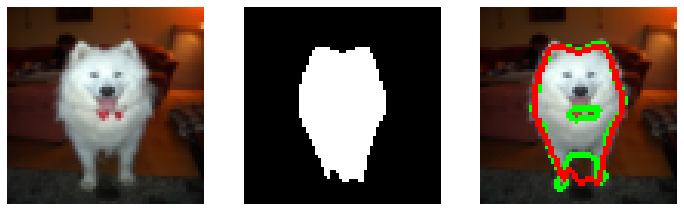

samoyed_95.jpg dice : 0.9108244531688166


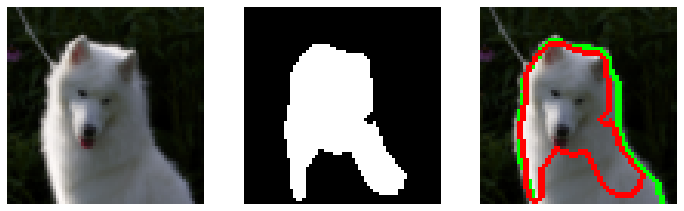

samoyed_96.jpg dice : 0.8092404620231012


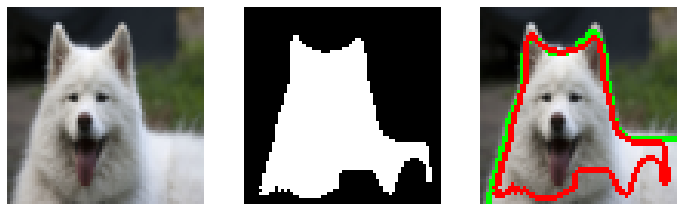

samoyed_97.jpg dice : 0.8451527224435591


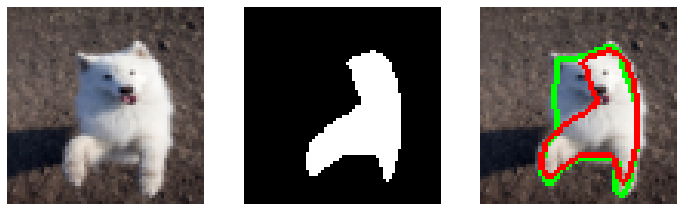

samoyed_98.jpg dice : 0.8105515587529976


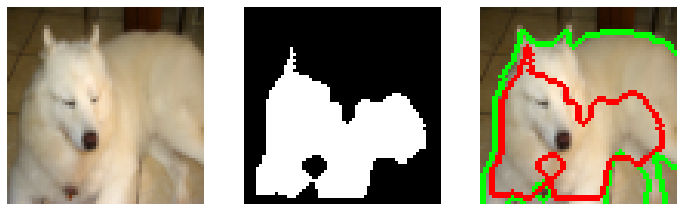

samoyed_99.jpg dice : 0.6759853345554537
average dice: 0.7191322379221117


In [155]:
dices_3 = make_prediction(model_3, test_idxs, test_imgs, test_segs, folder='./weights3.hdf5')
print('average dice:', np.mean(np.array(dices_3)))
os.remove('./weights3.hdf5')

**Question 10 -** The two following deep models (4 and 5) use the VGG16 classification network without (model 4) and with (model 5) pre-training on the ImageNet dataset. Run the training for both networks and (as previously) evaluate them.

In [119]:
def get_model_4(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
    return model


In [120]:
model_checkpoint = ModelCheckpoint('./weights4.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

In [121]:
batchepochs = 100
model_4 = get_model_4(size_, size_)
model_4.summary()
hist_4 = model_4.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 64, 64, 64)   1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_93[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_94[0][0]                  
__________________________________________________________________________________________________
conv2d_95 

Train on 160 samples, validate on 40 samples
Epoch 1/200
160/160 [==============================] - 3s 22ms/step - loss: -0.5857 - dice_coef: 0.5857 - val_loss: -0.6767 - val_dice_coef: 0.6767
Epoch 2/200
160/160 [==============================] - 1s 8ms/step - loss: -0.6806 - dice_coef: 0.6806 - val_loss: -0.7150 - val_dice_coef: 0.7150
Epoch 3/200
160/160 [==============================] - 1s 8ms/step - loss: -0.7316 - dice_coef: 0.7316 - val_loss: -0.7085 - val_dice_coef: 0.7085
Epoch 4/200
160/160 [==============================] - 1s 8ms/step - loss: -0.7393 - dice_coef: 0.7393 - val_loss: -0.7337 - val_dice_coef: 0.7337
Epoch 5/200
160/160 [==============================] - 1s 8ms/step - loss: -0.7703 - dice_coef: 0.7703 - val_loss: -0.7432 - val_dice_coef: 0.7432
Epoch 6/200
160/160 [==============================] - 1s 8ms/step - loss: -0.7888 - dice_coef: 0.7888 - val_loss: -0.7698 - val_dice_coef: 0.7698
Epoch 7/200
160/160 [==============================] - 1s 8ms/step - los

160/160 [==============================] - 1s 8ms/step - loss: -0.9952 - dice_coef: 0.9952 - val_loss: -0.8173 - val_dice_coef: 0.8173
Epoch 112/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9953 - dice_coef: 0.9953 - val_loss: -0.8194 - val_dice_coef: 0.8194
Epoch 113/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9952 - dice_coef: 0.9952 - val_loss: -0.8199 - val_dice_coef: 0.8199
Epoch 114/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9952 - dice_coef: 0.9952 - val_loss: -0.8176 - val_dice_coef: 0.8176
Epoch 115/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9950 - dice_coef: 0.9950 - val_loss: -0.8211 - val_dice_coef: 0.8211
Epoch 116/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9951 - dice_coef: 0.9951 - val_loss: -0.8187 - val_dice_coef: 0.8187
Epoch 117/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9955 - dice_coef: 0.9955 - val_loss: -0.

160/160 [==============================] - 1s 8ms/step - loss: -0.9484 - dice_coef: 0.9484 - val_loss: -0.8118 - val_dice_coef: 0.8118
Epoch 167/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9604 - dice_coef: 0.9604 - val_loss: -0.8237 - val_dice_coef: 0.8237
Epoch 168/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9695 - dice_coef: 0.9695 - val_loss: -0.8327 - val_dice_coef: 0.8327
Epoch 169/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9780 - dice_coef: 0.9780 - val_loss: -0.8255 - val_dice_coef: 0.8255
Epoch 170/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9846 - dice_coef: 0.9846 - val_loss: -0.8273 - val_dice_coef: 0.8273
Epoch 171/200
160/160 [==============================] - 1s 9ms/step - loss: -0.9880 - dice_coef: 0.9880 - val_loss: -0.8241 - val_dice_coef: 0.8241
Epoch 172/200
160/160 [==============================] - 1s 8ms/step - loss: -0.9900 - dice_coef: 0.9900 - val_loss: -0.

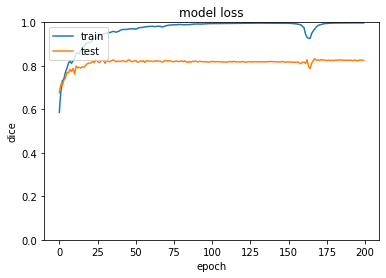

In [124]:
display_history(hist_4)

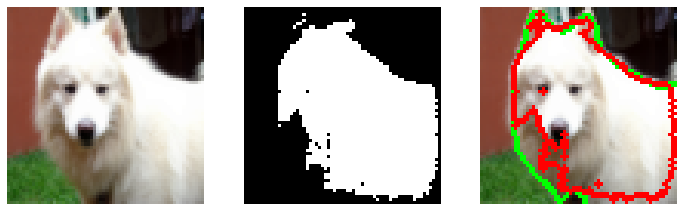

samoyed_63.jpg dice : 0.9011423550087874


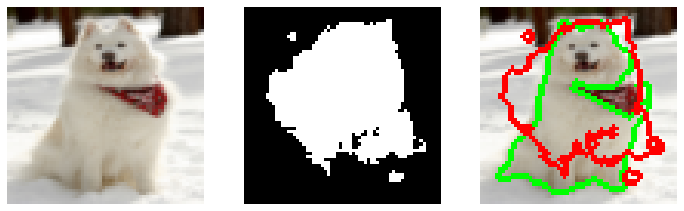

samoyed_64.jpg dice : 0.6804123711340206


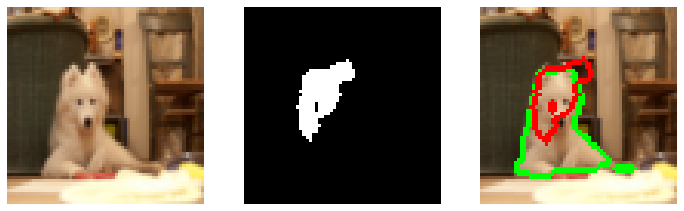

samoyed_65.jpg dice : 0.4936854190585534


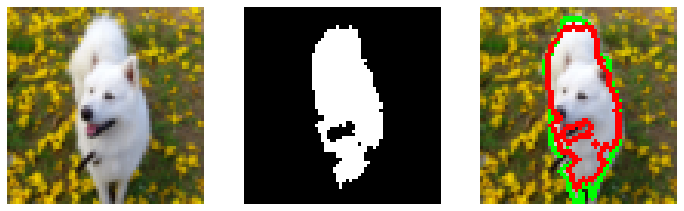

samoyed_66.jpg dice : 0.8910776361529548


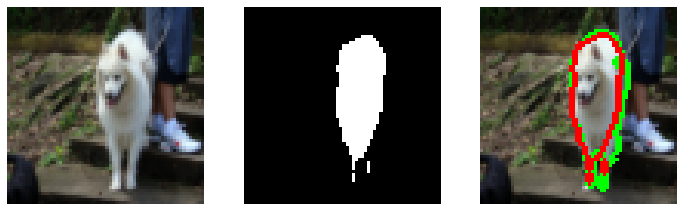

samoyed_67.jpg dice : 0.8758992805755396


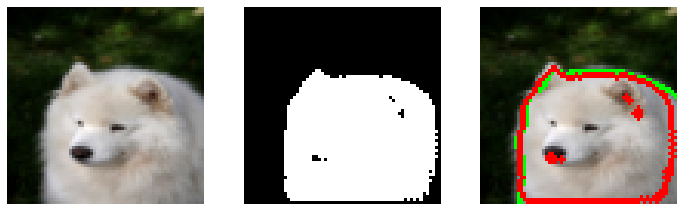

samoyed_68.jpg dice : 0.9403329065300896


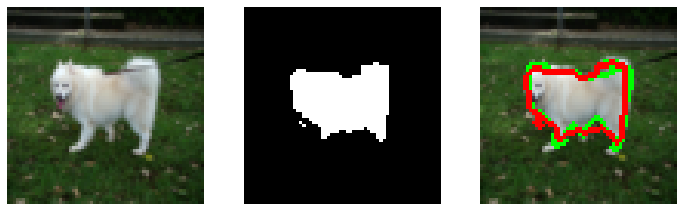

samoyed_69.jpg dice : 0.9055319148936171


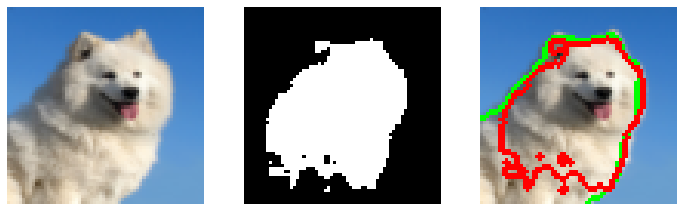

samoyed_7.jpg dice : 0.8270356572645023


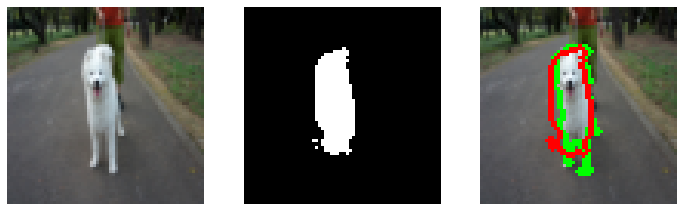

samoyed_70.jpg dice : 0.8023255813953488


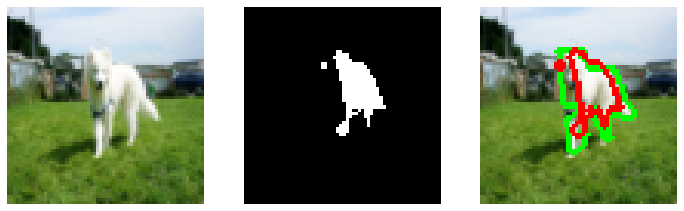

samoyed_71.jpg dice : 0.6482334869431644


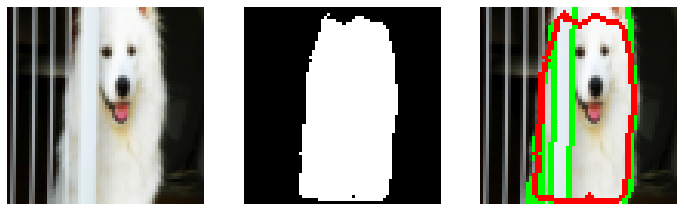

samoyed_72.jpg dice : 0.8104234527687296


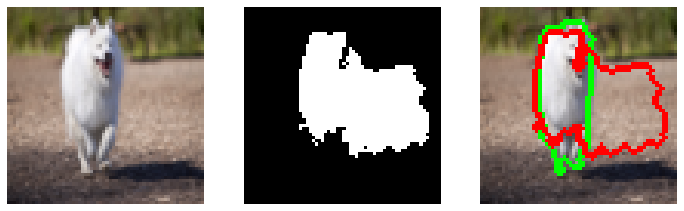

samoyed_73.jpg dice : 0.559648158328752


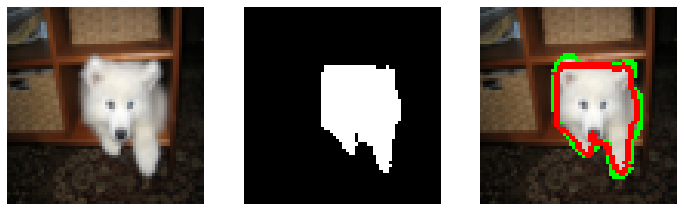

samoyed_74.jpg dice : 0.9198012775017743


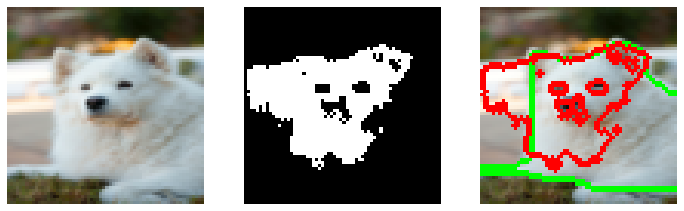

samoyed_75.jpg dice : 0.5625


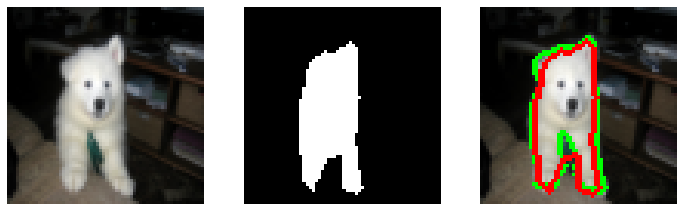

samoyed_76.jpg dice : 0.8947032546266752


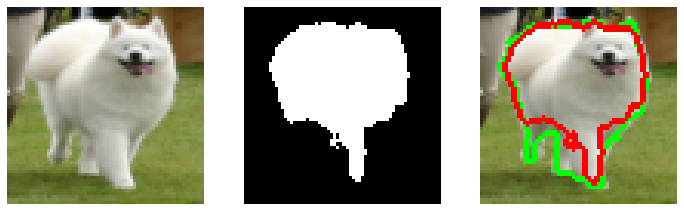

samoyed_77.jpg dice : 0.8995775105622359


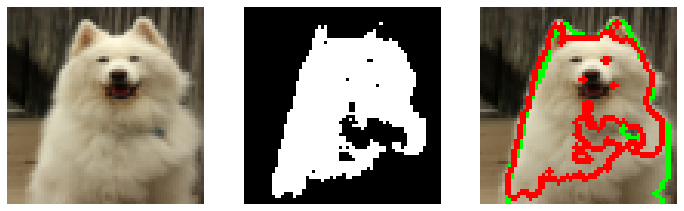

samoyed_78.jpg dice : 0.7930859176410778


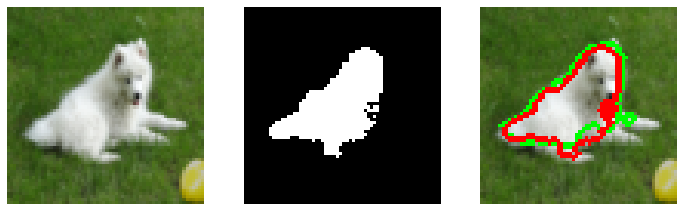

samoyed_79.jpg dice : 0.8743645606390704


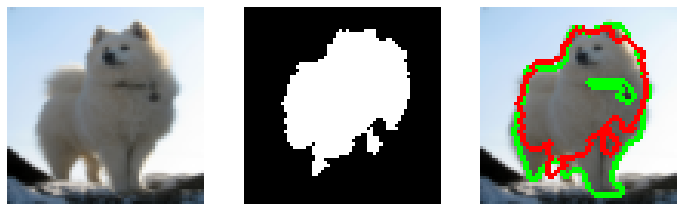

samoyed_8.jpg dice : 0.8191150442477876


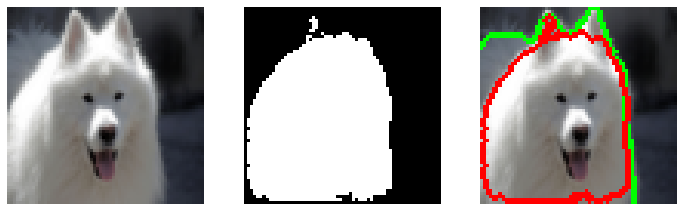

samoyed_80.jpg dice : 0.8930041152263375


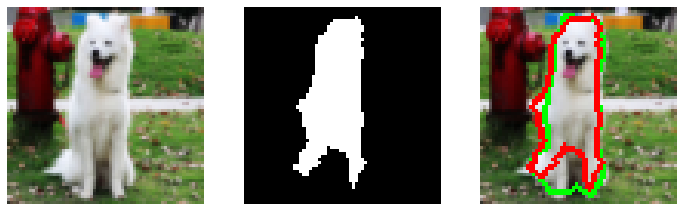

samoyed_81.jpg dice : 0.8456683878370626


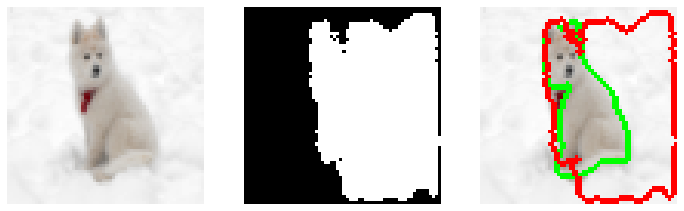

samoyed_82.jpg dice : 0.5020215633423181


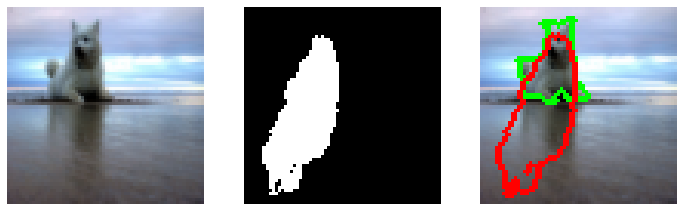

samoyed_83.jpg dice : 0.4469067405355494


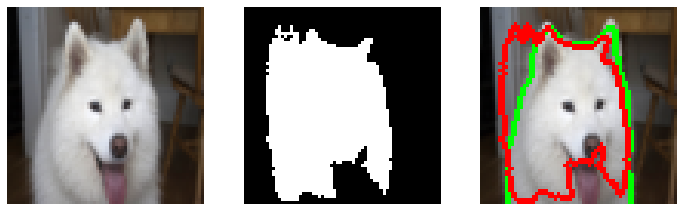

samoyed_84.jpg dice : 0.8302814976769609


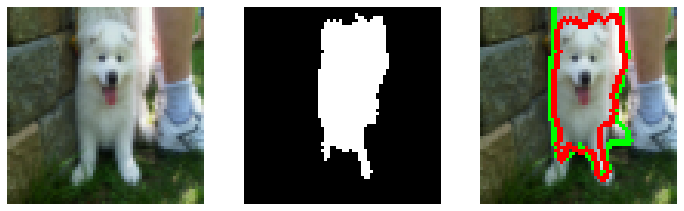

samoyed_85.jpg dice : 0.862356621480709


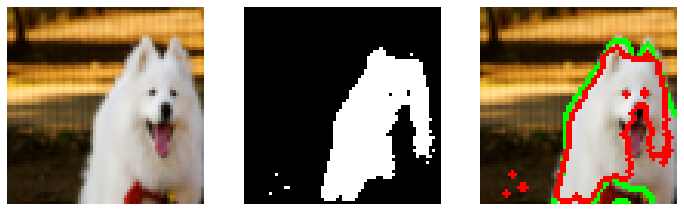

samoyed_86.jpg dice : 0.7971473851030111


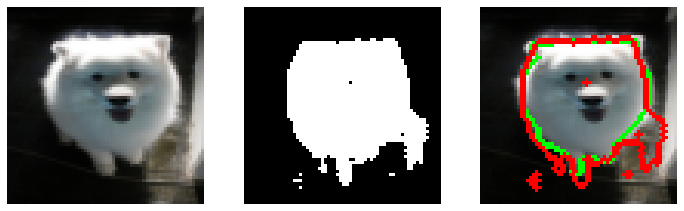

samoyed_87.jpg dice : 0.9019886363636364


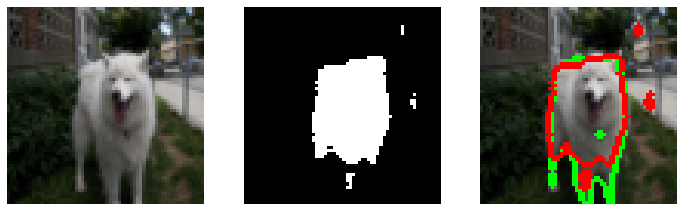

samoyed_88.jpg dice : 0.8844472204871955


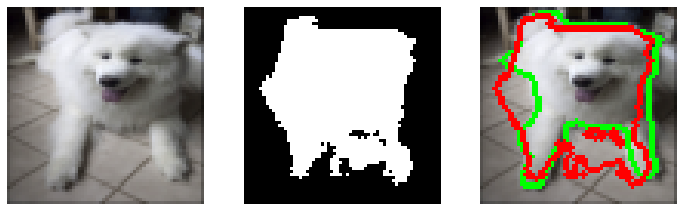

samoyed_89.jpg dice : 0.8048916064480267


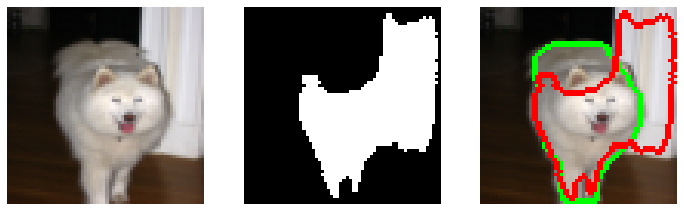

samoyed_9.jpg dice : 0.6318537859007833


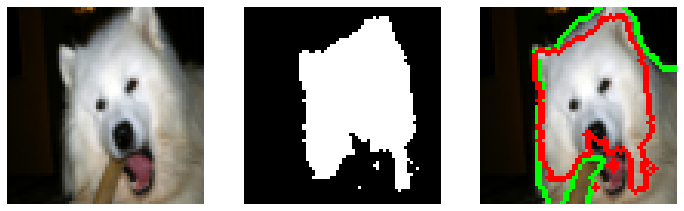

samoyed_90.jpg dice : 0.7492780257285376


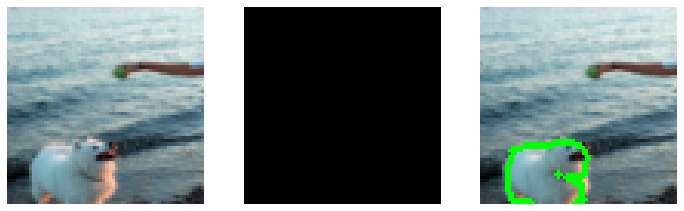

samoyed_91.jpg dice : 0.0


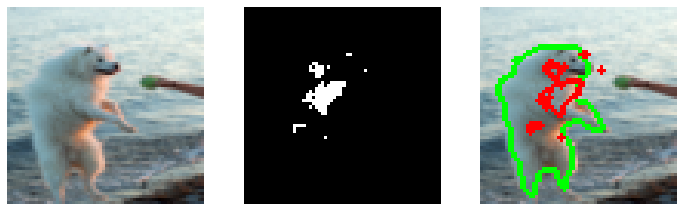

samoyed_92.jpg dice : 0.19318181818181818


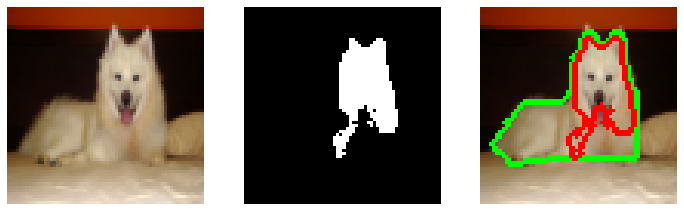

samoyed_93.jpg dice : 0.5614250614250614


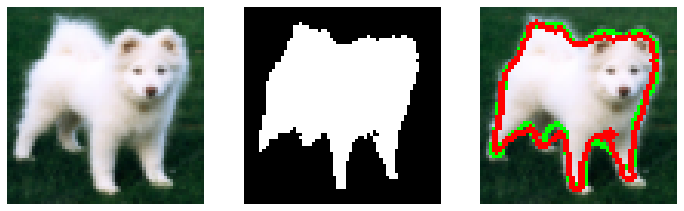

samoyed_94.jpg dice : 0.9447743467933492


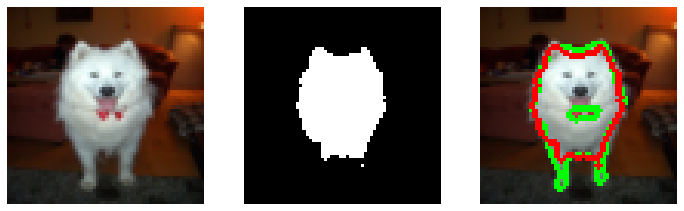

samoyed_95.jpg dice : 0.9034608378870674


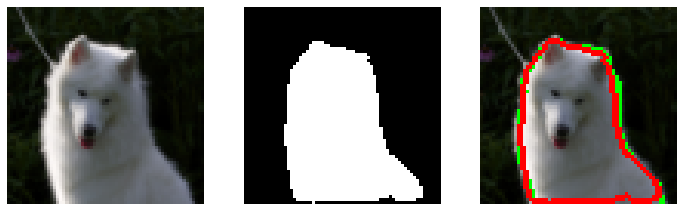

samoyed_96.jpg dice : 0.9637967751749316


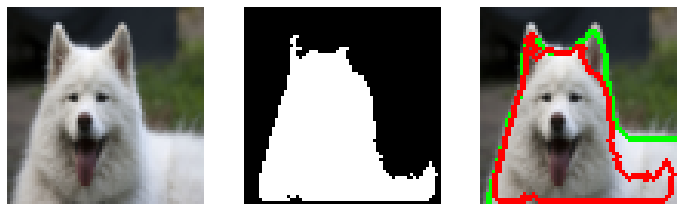

samoyed_97.jpg dice : 0.874967641729226


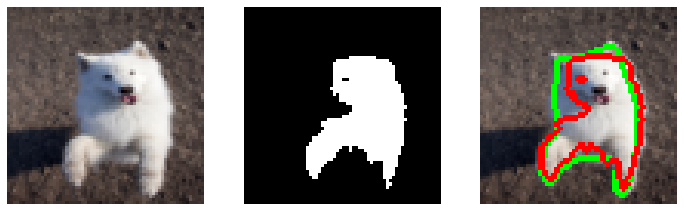

samoyed_98.jpg dice : 0.846979107848673


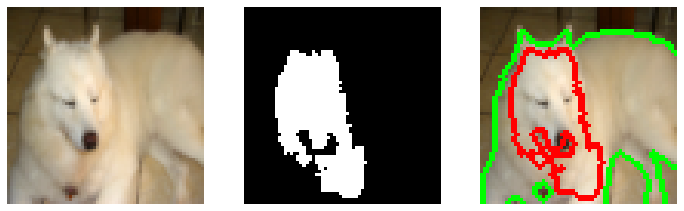

samoyed_99.jpg dice : 0.46100427350427353
average dice: 0.7499582808486802


In [129]:
dices_4 = make_prediction(model_4, test_idxs, test_imgs, test_segs, folder='./weights4.hdf5')
print('average dice:', np.mean(np.array(dices_4)))
os.remove('./weights4.hdf5')

In [130]:
from keras.applications import vgg16

def get_model_5(img_rows, img_cols, prediction_weights=None):

    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)
    
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(vgg16_model.get_layer('block5_conv3').output), vgg16_model.get_layer('block4_conv3').output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), vgg16_model.get_layer('block3_conv3').output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), vgg16_model.get_layer('block2_conv2').output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), vgg16_model.get_layer('block1_conv2').output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[conv10])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
    return model

In [131]:
model_checkpoint = ModelCheckpoint('./weights5.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

In [132]:
epochs = 50
model_5 = get_model_5(size_, size_)
model_5.summary()
hist_5 = model_5.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

Train on 160 samples, validate on 40 samples
Epoch 1/50
160/160 [==============================] - 3s 20ms/step - loss: -0.5559 - dice_coef: 0.5559 - val_loss: -0.7259 - val_dice_coef: 0.7259
Epoch 2/50
160/160 [==============================] - 1s 8ms/step - loss: -0.8178 - dice_coef: 0.8178 - val_loss: -0.8670 - val_dice_coef: 0.8670
Epoch 3/50
160/160 [==============================] - 1s 8ms/step - loss: -0.8853 - dice_coef: 0.8853 - val_loss: -0.8690 - val_dice_coef: 0.8690
Epoch 4/50
160/160 [==============================] - 1s 8ms/step - loss: -0.9075 - dice_coef: 0.9075 - val_loss: -0.8895 - val_dice_coef: 0.8895
Epoch 5/50
160/160 [==============================] - 1s 8ms/step - loss: -0.9218 - dice_coef: 0.9218 - val_loss: -0.9035 - val_dice_coef: 0.9035
Epoch 6/50
160/160 [==============================] - 1s 8ms/step - loss: -0.9254 - dice_coef: 0.9254 - val_loss: -0.8765 - val_dice_coef: 0.8765
Epoch 7/50
160/160 [==============================] - 1s 8ms/step - loss: -0.9

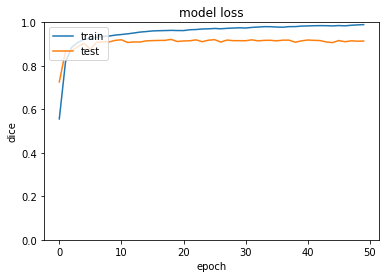

In [133]:
display_history(hist_5)

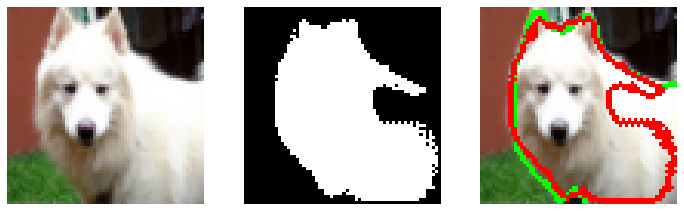

samoyed_63.jpg dice : 0.8959018189787421


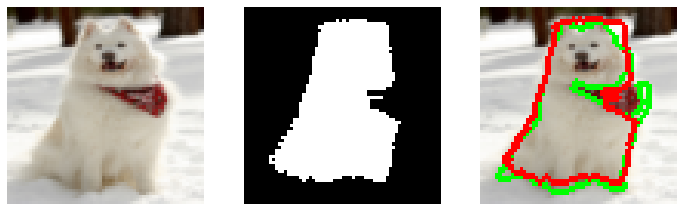

samoyed_64.jpg dice : 0.9025778372949448


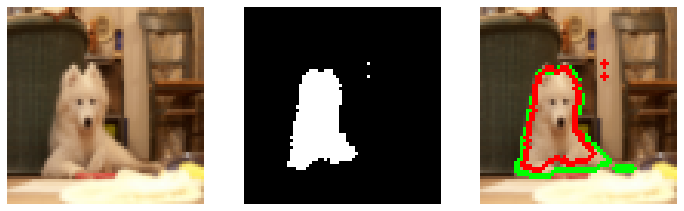

samoyed_65.jpg dice : 0.8558310376492194


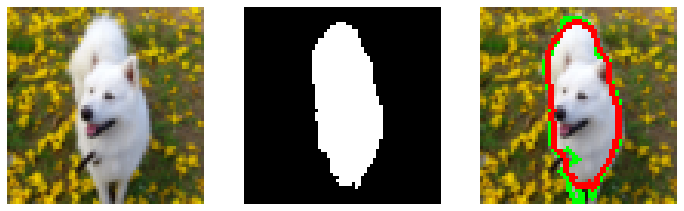

samoyed_66.jpg dice : 0.9437837837837838


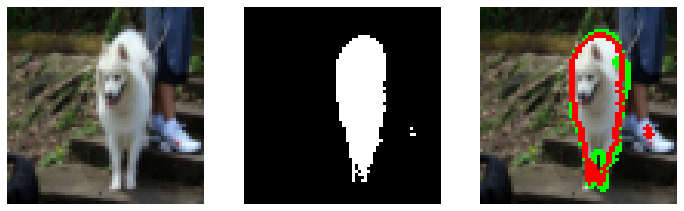

samoyed_67.jpg dice : 0.9055319148936171


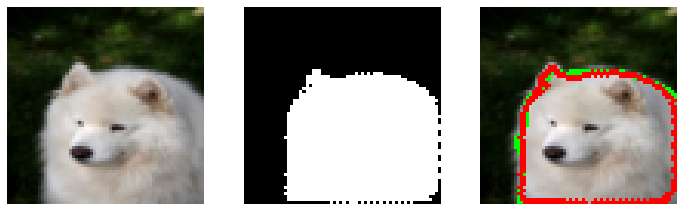

samoyed_68.jpg dice : 0.9676286072772898


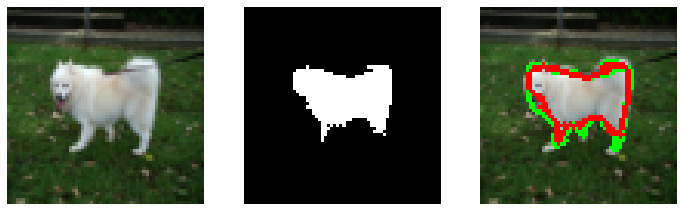

samoyed_69.jpg dice : 0.8940092165898618


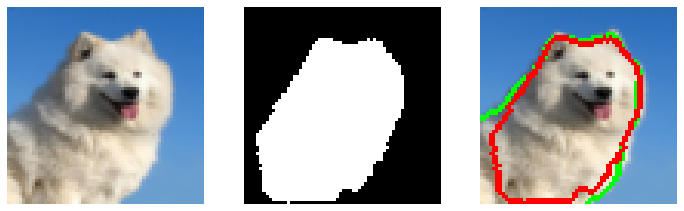

samoyed_7.jpg dice : 0.9177810797424467


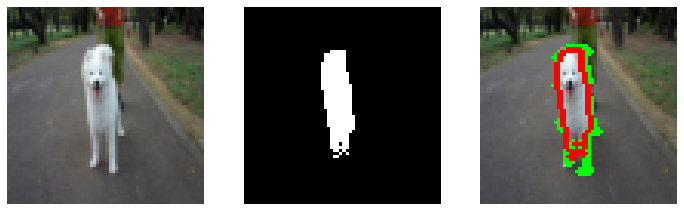

samoyed_70.jpg dice : 0.8537414965986394


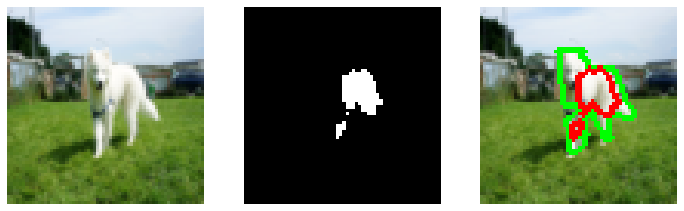

samoyed_71.jpg dice : 0.5252173913043479


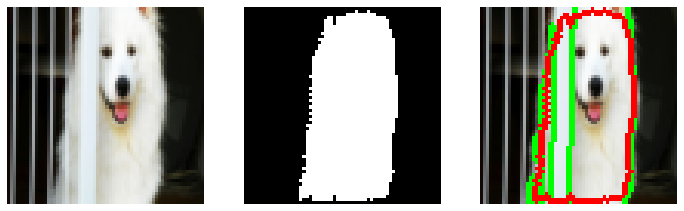

samoyed_72.jpg dice : 0.8253760627861347


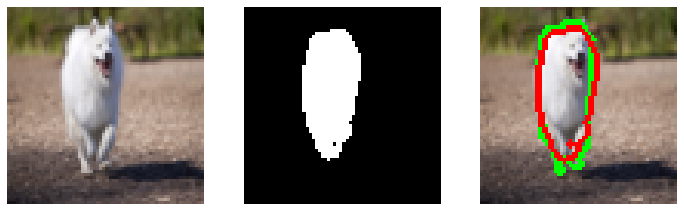

samoyed_73.jpg dice : 0.9120370370370371


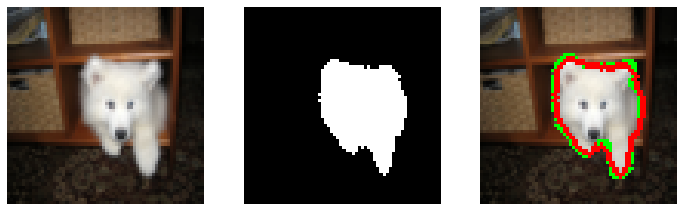

samoyed_74.jpg dice : 0.9432432432432433


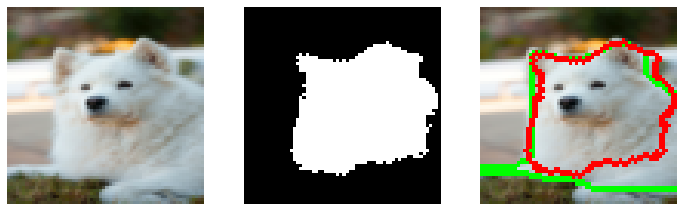

samoyed_75.jpg dice : 0.8491268250787289


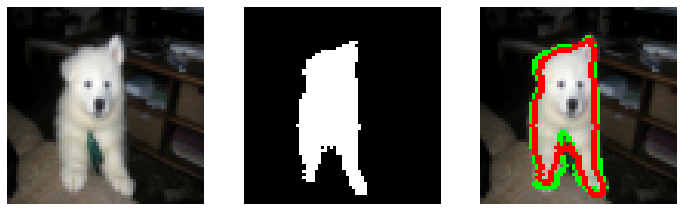

samoyed_76.jpg dice : 0.8972691807542262


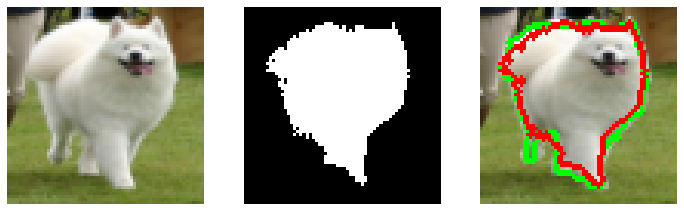

samoyed_77.jpg dice : 0.9314808967477107


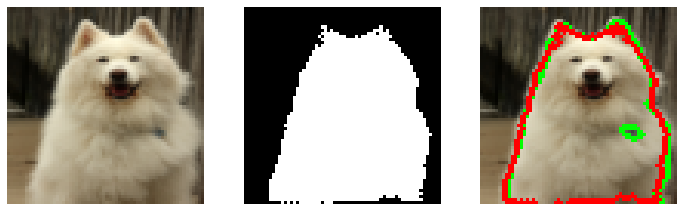

samoyed_78.jpg dice : 0.9597913497065855


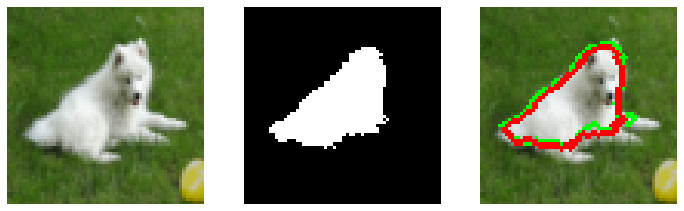

samoyed_79.jpg dice : 0.922425952045134


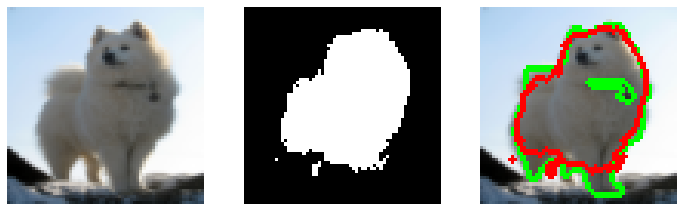

samoyed_8.jpg dice : 0.877914951989026


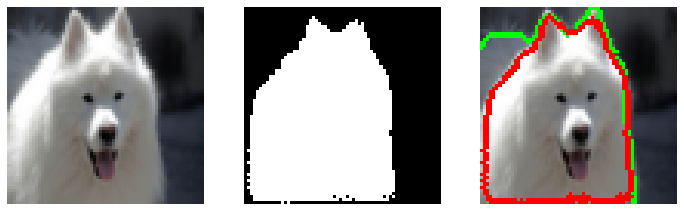

samoyed_80.jpg dice : 0.9124647035094796


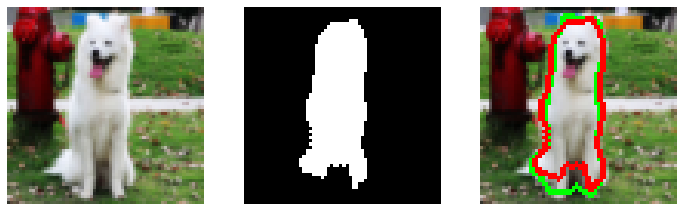

samoyed_81.jpg dice : 0.9023717595146167


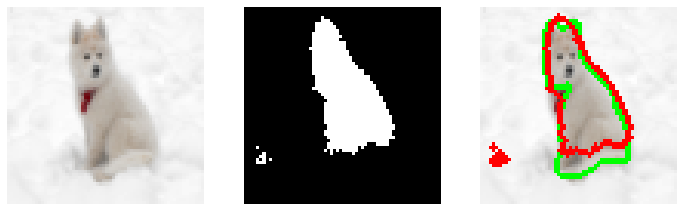

samoyed_82.jpg dice : 0.818242790073776


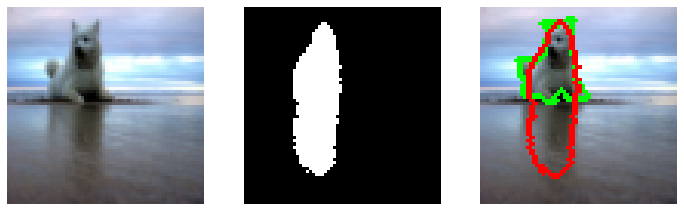

samoyed_83.jpg dice : 0.5844845908607864


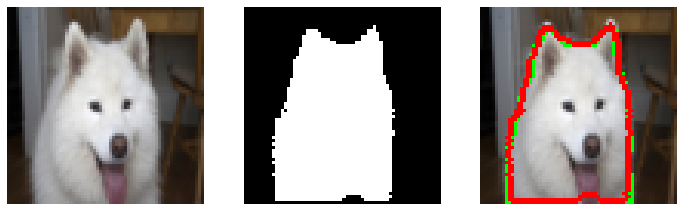

samoyed_84.jpg dice : 0.9653691275167785


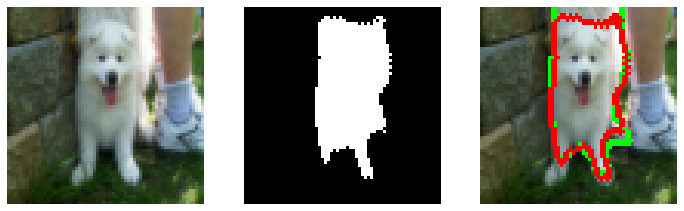

samoyed_85.jpg dice : 0.9083743842364532


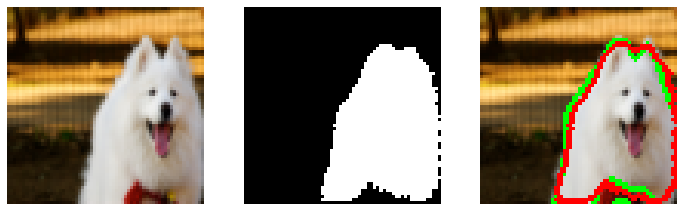

samoyed_86.jpg dice : 0.9362416107382551


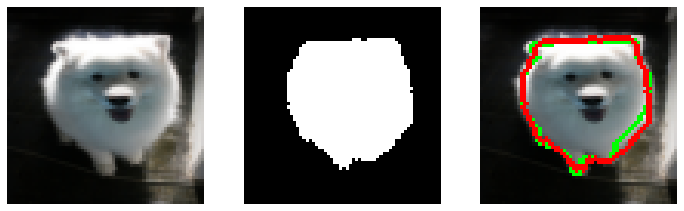

samoyed_87.jpg dice : 0.9571106094808126


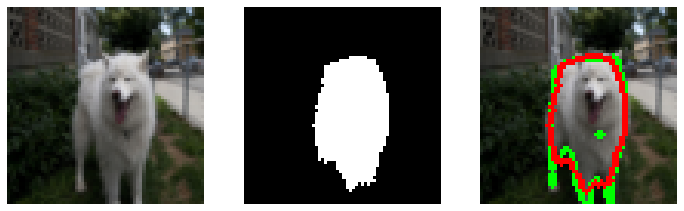

samoyed_88.jpg dice : 0.9333333333333333


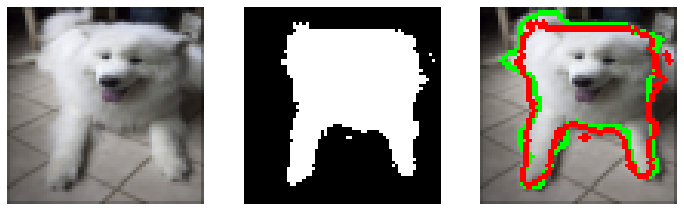

samoyed_89.jpg dice : 0.9124507724931838


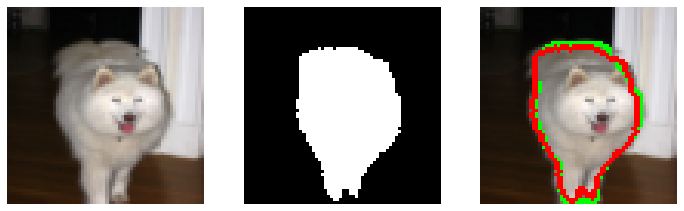

samoyed_9.jpg dice : 0.9573344169036977


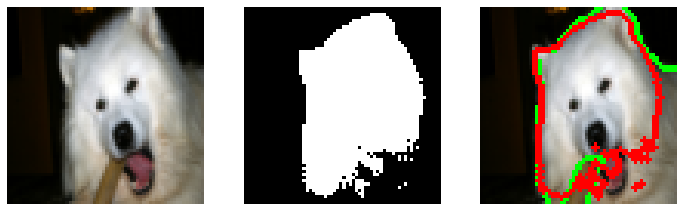

samoyed_90.jpg dice : 0.8155008530343651


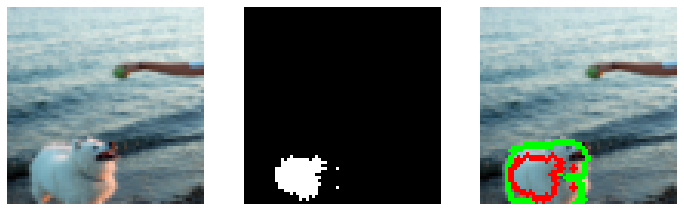

samoyed_91.jpg dice : 0.5531914893617021


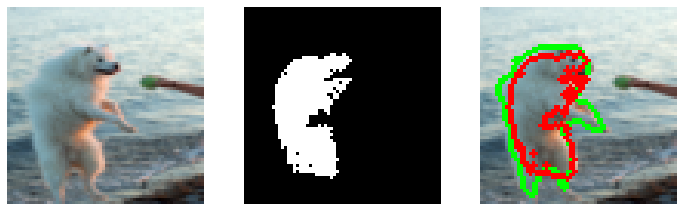

samoyed_92.jpg dice : 0.7807620237351656


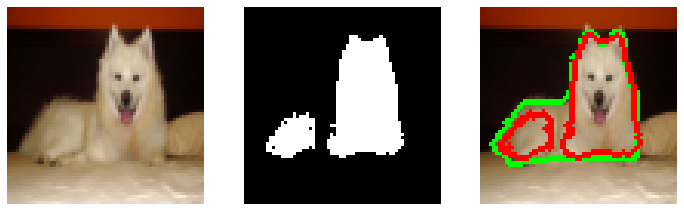

samoyed_93.jpg dice : 0.84765625


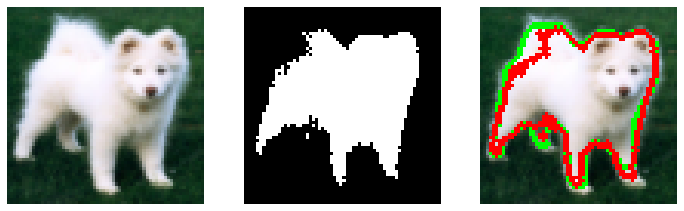

samoyed_94.jpg dice : 0.9231711049892868


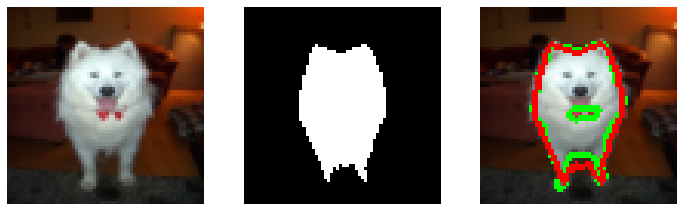

samoyed_95.jpg dice : 0.9235095613048369


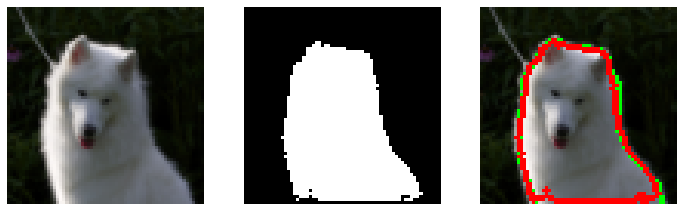

samoyed_96.jpg dice : 0.9635701275045537


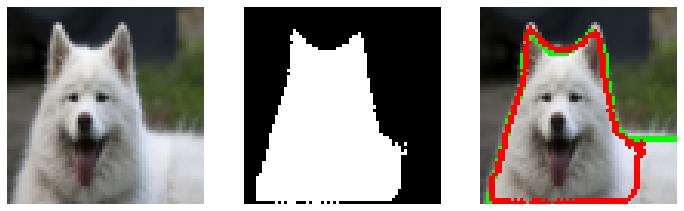

samoyed_97.jpg dice : 0.9029514757378689


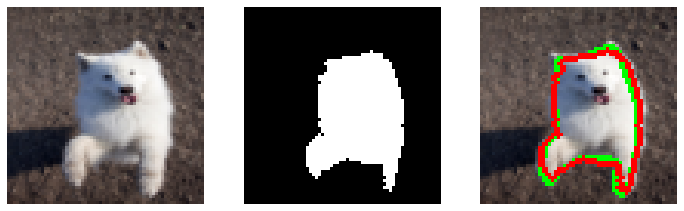

samoyed_98.jpg dice : 0.9361267245784364


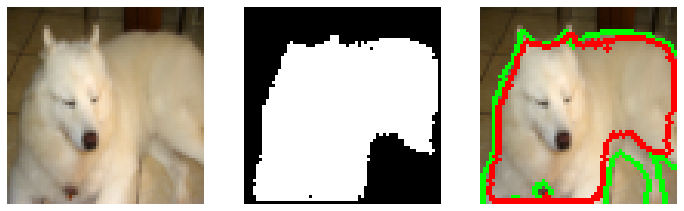

samoyed_99.jpg dice : 0.9008123937275647
average dice: 0.8778924946533919


In [134]:
dices_5 = make_prediction(model_5, test_idxs, test_imgs, test_segs, folder='./weights5.hdf5')
print('average dice:', np.mean(np.array(dices_5)))
os.remove('./weights5.hdf5')

**Question 11 -** Based on the figure below and average dice scores, comment on the segmentation accuracy reached for the 5 models. What is the best model and why?

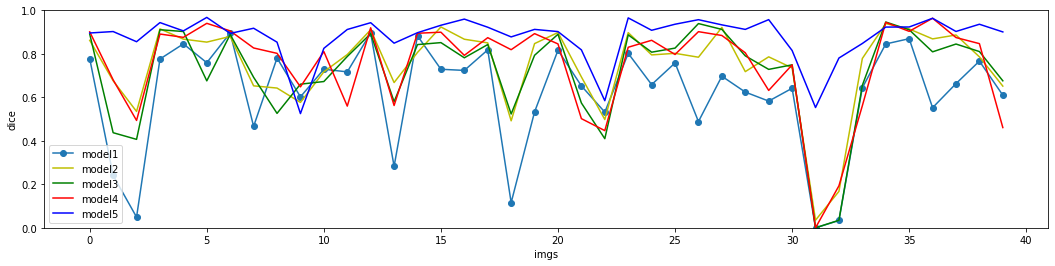

In [156]:
plt.figure(figsize=(18, 4))
plt.plot(dices_1,'o-')
plt.plot(dices_2,'y-')
plt.plot(dices_3,'g-')
plt.plot(dices_4,'r-')
plt.plot(dices_5,'b-')
plt.ylabel('dice')
plt.ylim([0,1])     
plt.xlabel('imgs')
plt.legend(['model1', 'model2','model3', 'model4','model5'], loc='lower left')
plt.show()

**Answer**: We can see that the best model is the model 5. As model 5 is a pretrained vgg16 adapted by transfer learning, it is expected for it to have the best performances. The vgg16 was pretrained with the ImageNet dataset, which is big and variated and that gives the network good generalization capabilities.

***

## II - Object detection

The goal of the 2nd part is to create an automatic **face detection model** with deep learning able to accurately localize *samoyed* heads in each image by mean of a bounding box. Groundtruth bounding box coordinates are provided in XML files for 99 images. 

In [10]:
import xml.etree.ElementTree as ET
def xml2coordinates(xmlpath):
    tree = ET.parse(xmlpath)
    height = int(tree.findtext("./size/height"))
    width = int(tree.findtext("./size/width"))
    xmin = int(tree.findtext("./object/bndbox/xmin"))
    xmax = int(tree.findtext("./object/bndbox/xmax"))
    ymin = int(tree.findtext("./object/bndbox/ymin"))
    ymax = int(tree.findtext("./object/bndbox/ymax"))
    return height, width, xmin, xmax, ymin, ymax

Let us rebuild our dataset with associated bounding box coordinates (extracted from XML files).

In [11]:
folder_xml = './samoyed_xml/'

list_ = listdir_nohidden(folder_xml)
idxs = []

imgs = np.ndarray((len(list_), size_, size_, 3), dtype=np.float32)
xmins = np.ndarray(len(list_), dtype=np.uint8)
xmaxs = np.ndarray(len(list_), dtype=np.uint8)
ymins = np.ndarray(len(list_), dtype=np.uint8)
ymaxs = np.ndarray(len(list_), dtype=np.uint8)
for idx, id_ in enumerate(list_):
    name = id_.split('.')[0]
    xmlpath = './samoyed_xml/'+name+'.xml'
    height, width, xmin, xmax, ymin, ymax = xml2coordinates(xmlpath)
    img = io.imread(folder_img+name+'.jpg')
    imgs[idx,...] = resize(img,output_shape=(size_,size_),mode='reflect',preserve_range=True)
    xmins[idx] = np.int(np.floor(size_*ymin/height))
    xmaxs[idx] = np.int(np.floor(size_*ymax/height))
    ymins[idx] = np.int(np.floor(size_*xmin/width))
    ymaxs[idx] = np.int(np.floor(size_*xmax/width))
    idxs.append(name)

**Question 12 -** Normalize the dataset and use the **visualize_predicted_box()** function to visualize the first eight images with super-imposed bounding boxes.

In [15]:
def visualize_predicted_box(img, xmin, xmax, ymin, ymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(0, 1, 0))
    return out

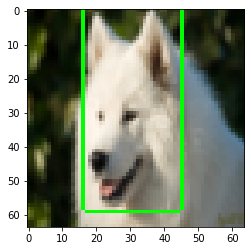

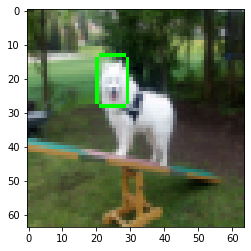

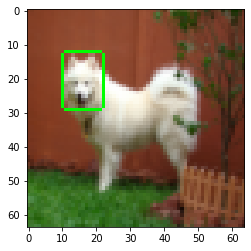

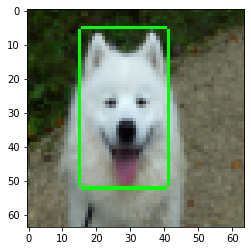

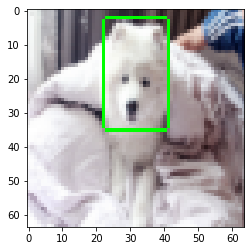

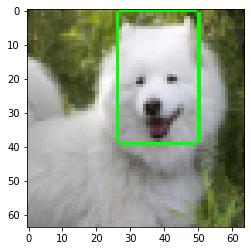

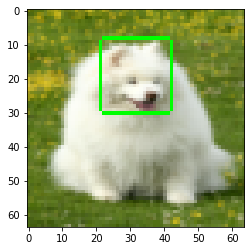

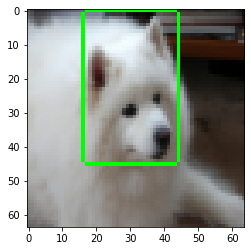

In [33]:
normalization(imgs)  
for i in range(8):
    img = io.imread(folder_img+'samoyed_1.jpg')
    plt.figure(figsize=(18, 4))
    out = visualize_predicted_box(imgs[i,:,:,:],xmins[i],xmaxs[i],ymins[i],ymaxs[i])
    plt.imshow(out)
    plt.show()

**Question 13 -** Using pre-trained VGG16 and fully-connected layers, build a deep regression model able to infer the 4 bounding box coordinates from a given intput image. The mean absolute error (**mean_absolute_error**) will be used as loss function. 

In [59]:
from keras.layers import Dense, Flatten, concatenate, Conv2D, Conv2DTranspose
from keras.applications import vgg16
from keras.layers import concatenate

def get_model_6(img_rows, img_cols, prediction_weights=None):
    
    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)  
    
    flatten = Flatten()(vgg16_model.get_layer('block5_conv3').output)
    dense = Dense(256)(flatten)
    dense = Dense(128)(dense)
    dense = Dense(64)(dense)
    dense = Dense(32)(dense)
    dense = Dense(4)(dense)
    
    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[dense])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss='mean_absolute_error', metrics=['mean_absolute_error'])
    
    return model

In [60]:
model_6 = get_model_6(size_, size_)
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

**Question 14 -** Divide the dataset into training and test subsets (with a ratio of 70%), run the training and display how evolves the loss function during training for both subsets. 

In [74]:
ratio = 0.7
split = np.int(len(imgs)*ratio)

train_imgs = imgs[0:split] # training images
train_xmins = xmins[0:split]
train_xmaxs = xmaxs[0:split]
train_ymins = ymins[0:split]
train_ymaxs = ymaxs[0:split]

test_imgs = imgs[split::] # test images
test_xmins = xmins[split::]
test_xmaxs = xmaxs[split::]
test_ymins = ymins[split::]
test_ymaxs = ymaxs[split::]

In [76]:
batch_size = 10
epochs = 200

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_mean_absolute_error', verbose=0, save_best_only=False, save_weights_only=True, mode='max', period=1)

In [77]:
train_coords = np.vstack([train_xmins,train_xmaxs,train_ymins,train_ymaxs]).T
test_coords = np.vstack([test_xmins,test_xmaxs,test_ymins,test_ymaxs]).T

hist_6 = model_6.fit(train_imgs, train_coords, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_coords), callbacks=[model_checkpoint])

Train on 68 samples, validate on 30 samples
Epoch 1/200
68/68 [==============================] - 4s 57ms/step - loss: 17.7139 - mean_absolute_error: 17.7139 - val_loss: 8.8407 - val_mean_absolute_error: 8.8407
Epoch 2/200
68/68 [==============================] - 0s 5ms/step - loss: 8.3293 - mean_absolute_error: 8.3293 - val_loss: 8.8736 - val_mean_absolute_error: 8.8736
Epoch 3/200
68/68 [==============================] - 0s 4ms/step - loss: 6.8154 - mean_absolute_error: 6.8154 - val_loss: 6.7650 - val_mean_absolute_error: 6.7650
Epoch 4/200
68/68 [==============================] - 0s 4ms/step - loss: 5.5927 - mean_absolute_error: 5.5927 - val_loss: 5.5474 - val_mean_absolute_error: 5.5474
Epoch 5/200
68/68 [==============================] - 0s 5ms/step - loss: 4.8972 - mean_absolute_error: 4.8972 - val_loss: 6.0217 - val_mean_absolute_error: 6.0217
Epoch 6/200
68/68 [==============================] - 0s 4ms/step - loss: 4.5166 - mean_absolute_error: 4.5166 - val_loss: 5.8726 - val_mea

Epoch 51/200
68/68 [==============================] - 0s 4ms/step - loss: 0.8980 - mean_absolute_error: 0.8980 - val_loss: 3.9437 - val_mean_absolute_error: 3.9437
Epoch 52/200
68/68 [==============================] - 0s 4ms/step - loss: 1.0105 - mean_absolute_error: 1.0105 - val_loss: 3.8314 - val_mean_absolute_error: 3.8314
Epoch 53/200
68/68 [==============================] - 0s 5ms/step - loss: 1.0324 - mean_absolute_error: 1.0324 - val_loss: 4.0441 - val_mean_absolute_error: 4.0441
Epoch 54/200
68/68 [==============================] - 0s 4ms/step - loss: 0.8612 - mean_absolute_error: 0.8612 - val_loss: 4.0128 - val_mean_absolute_error: 4.0128
Epoch 55/200
68/68 [==============================] - 0s 4ms/step - loss: 1.1663 - mean_absolute_error: 1.1663 - val_loss: 4.0331 - val_mean_absolute_error: 4.0331
Epoch 56/200
68/68 [==============================] - 0s 4ms/step - loss: 1.1481 - mean_absolute_error: 1.1481 - val_loss: 4.0439 - val_mean_absolute_error: 4.0439
Epoch 57/200
68/

Epoch 101/200
68/68 [==============================] - 0s 5ms/step - loss: 0.7881 - mean_absolute_error: 0.7881 - val_loss: 3.7538 - val_mean_absolute_error: 3.7538
Epoch 102/200
68/68 [==============================] - 0s 5ms/step - loss: 0.7222 - mean_absolute_error: 0.7222 - val_loss: 3.7665 - val_mean_absolute_error: 3.7665
Epoch 103/200
68/68 [==============================] - 0s 4ms/step - loss: 0.6972 - mean_absolute_error: 0.6972 - val_loss: 3.7508 - val_mean_absolute_error: 3.7508
Epoch 104/200
68/68 [==============================] - 0s 5ms/step - loss: 0.8257 - mean_absolute_error: 0.8257 - val_loss: 3.9574 - val_mean_absolute_error: 3.9574
Epoch 105/200
68/68 [==============================] - 0s 4ms/step - loss: 1.0913 - mean_absolute_error: 1.0913 - val_loss: 4.0592 - val_mean_absolute_error: 4.0592
Epoch 106/200
68/68 [==============================] - 0s 4ms/step - loss: 1.1422 - mean_absolute_error: 1.1422 - val_loss: 4.0462 - val_mean_absolute_error: 4.0462
Epoch 107/

Epoch 151/200
68/68 [==============================] - 0s 4ms/step - loss: 0.7940 - mean_absolute_error: 0.7940 - val_loss: 3.7677 - val_mean_absolute_error: 3.7677
Epoch 152/200
68/68 [==============================] - 0s 4ms/step - loss: 0.7126 - mean_absolute_error: 0.7126 - val_loss: 3.7397 - val_mean_absolute_error: 3.7397
Epoch 153/200
68/68 [==============================] - 0s 4ms/step - loss: 0.6414 - mean_absolute_error: 0.6414 - val_loss: 3.7044 - val_mean_absolute_error: 3.7044
Epoch 154/200
68/68 [==============================] - 0s 5ms/step - loss: 0.6185 - mean_absolute_error: 0.6185 - val_loss: 3.7262 - val_mean_absolute_error: 3.7262
Epoch 155/200
68/68 [==============================] - 0s 4ms/step - loss: 0.5597 - mean_absolute_error: 0.5597 - val_loss: 3.7238 - val_mean_absolute_error: 3.7238
Epoch 156/200
68/68 [==============================] - 0s 4ms/step - loss: 0.7507 - mean_absolute_error: 0.7507 - val_loss: 3.7600 - val_mean_absolute_error: 3.7600
Epoch 157/

In [78]:
def display_history_2(hist):
    plt.plot(hist.history['mean_absolute_error'])
    plt.plot(hist.history['val_mean_absolute_error'])
    plt.title('model loss')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

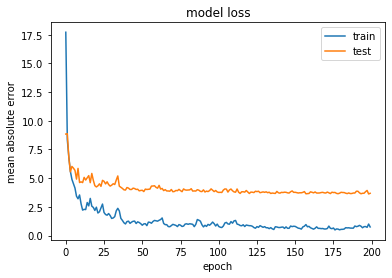

In [79]:
display_history_2(hist_6)

**Question 15 -** Use the **visualize_predicted_boxes()** function to display the prediction and groundtruth bounding boxes.

In [80]:
def visualize_predicted_boxes(img, xmin, xmax, ymin, ymax, GTxmin, GTxmax, GTymin, GTymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(1, 0, 0), background_label=2)
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[GTxmin:GTxmax+1, GTymin:GTymax+1] = 1
    out = mark_boundaries(out, mask, color=(0, 1, 0), background_label=4)
    return out

samoyed_162.xml


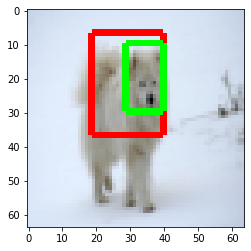

samoyed_163.xml


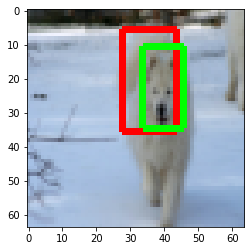

samoyed_164.xml


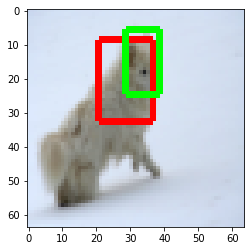

samoyed_165.xml


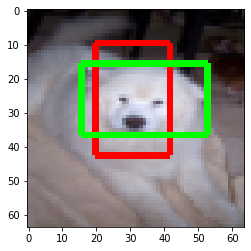

samoyed_166.xml


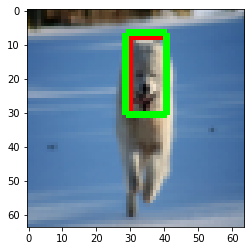

samoyed_167.xml


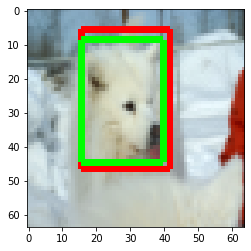

samoyed_168.xml


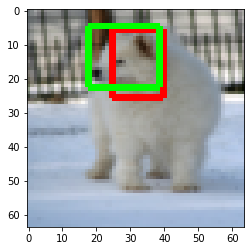

samoyed_169.xml


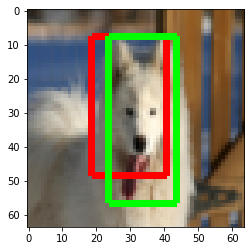

samoyed_17.xml


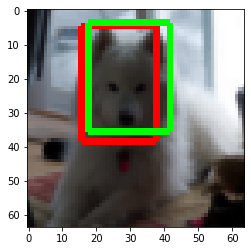

samoyed_170.xml


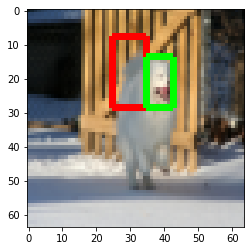

samoyed_171.xml


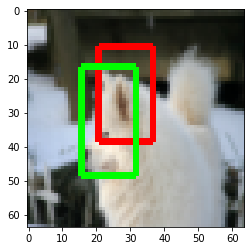

samoyed_172.xml


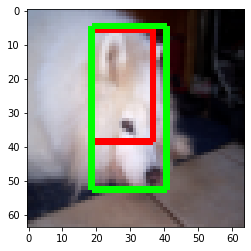

samoyed_173.xml


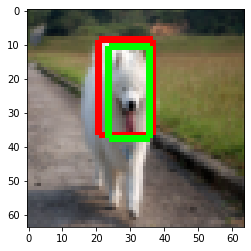

samoyed_174.xml


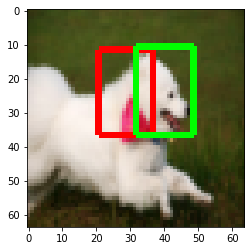

samoyed_175.xml


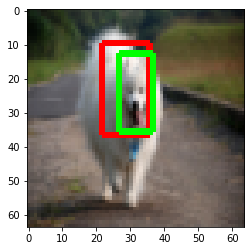

samoyed_176.xml


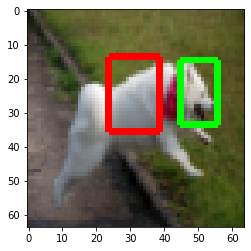

samoyed_177.xml


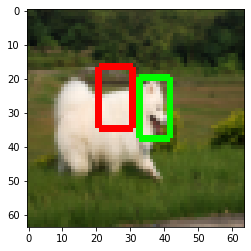

samoyed_178.xml


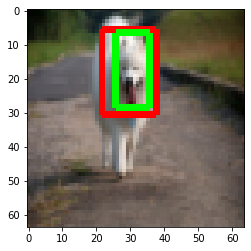

samoyed_179.xml


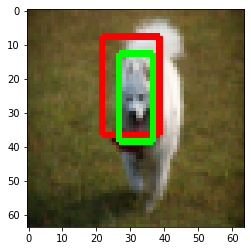

samoyed_18.xml


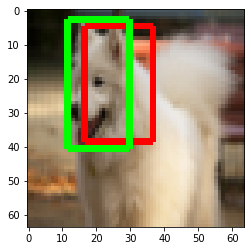

samoyed_180.xml


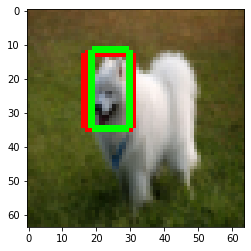

samoyed_181.xml


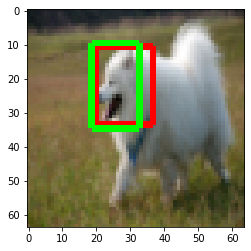

samoyed_182.xml


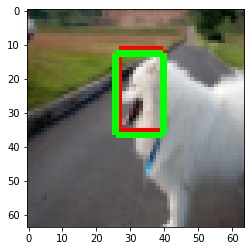

samoyed_183.xml


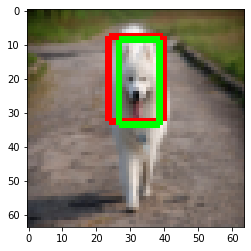

samoyed_184.xml


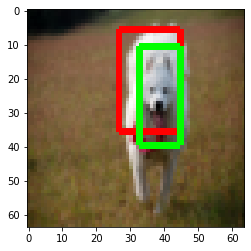

samoyed_186.xml


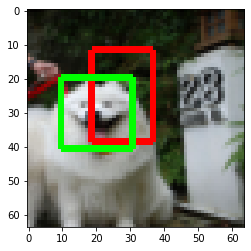

samoyed_187.xml


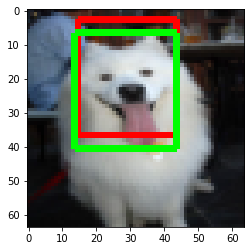

samoyed_188.xml


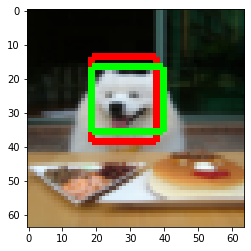

samoyed_189.xml


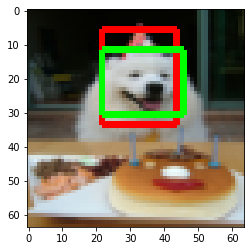

samoyed_190.xml


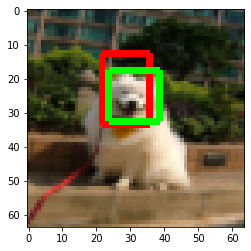

In [101]:
model_6.load_weights('./weights.hdf5')
for idx, id_ in enumerate(test_idxs):
    print(id_)
    xmin, xmax, ymin, ymax = model_6.predict(np.expand_dims(test_imgs[idx],axis=0))[0].astype(np.uint8)
    GTxmin,GTxmax, GTymin, GTymax = test_coords[idx,:]
    plt.imshow(visualize_predicted_boxes(test_imgs[idx],xmin, xmax, ymin, ymax,GTxmin,GTxmax,GTymin,GTymax))
    plt.show()